



&nbsp;

__DSC680_APPLIED DATA SCIENCE_SUMMER2025__



&nbsp;

__Week 4- Project Milestone-III__
&nbsp;

__Project Title: URBAN AIR POLLUTION FORECASTING WITH TIME SERIES AND MACHINE LEARNING__
&nbsp;

__Subtitle : Predicting PM2.5 Levels in Los Angeles using Weather and OpenAQ Data__

&nbsp;

__Phase : PROJECT MILESTONE III: Code__


&nbsp;

__Author : Sayali Nage__
&nbsp;

__Date Created(Ver1) : 06/30/2025__
&nbsp;

__Instructor : Matthew Metzger__

&nbsp;

__BELLEVUE UNIVERSITY, NEBRASKA(NE)__

# Environment Setup

## Import Required Libraries

In [1]:
# Standard libraries
import os
import pandas as pd
import numpy as np
import ast
import requests
import re
import time
from datetime import datetime, timedelta, timezone 
from dateutil import parser
from tqdm import tqdm
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Moedling and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
# Set working directory
dirpath = os.getcwd()

In [3]:
# Function to load required datasets
# Takes filename as input and returns a pandas DataFrame
def load_data(filename):

    # Construct the full file path
    # dirpath = os.getcwd()
    filepath = os.path.join(dirpath, "data", filename)

    try:
        df = pd.read_csv(filepath)
        print(f"Data loaded successfully from: {filepath}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure the file exists in the 'data' subdirectory.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading {filepath}: {e}")
        return None

In [4]:
# Load each dataset by simply providing its filename
hourly_weather = load_data("hourly_weather_df_new.csv")
hourly_pm25 = load_data("hourly_pm25_df_new.csv")

Data loaded successfully from: /home/jovyan/work/DSC_680/data/hourly_weather_df_new.csv
Data loaded successfully from: /home/jovyan/work/DSC_680/data/hourly_pm25_df_new.csv


In [5]:
if hourly_weather is not None and hourly_pm25 is not None:
    print("\nBoth weather and PM2.5 dataframes are loaded and ready for preprocessing.")


Both weather and PM2.5 dataframes are loaded and ready for preprocessing.


In [6]:
# Display structure of datasets
print("\n\033[1mHourly Weather Data:\033[0m\n")
display(hourly_weather.info())


Hourly Weather Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          4338 non-null   int64  
 1   sunrise     4338 non-null   int64  
 2   sunset      4338 non-null   int64  
 3   temp        4338 non-null   float64
 4   feels_like  4338 non-null   float64
 5   pressure    4338 non-null   int64  
 6   humidity    4338 non-null   int64  
 7   dew_point   4338 non-null   float64
 8   clouds      4338 non-null   int64  
 9   wind_speed  4338 non-null   float64
 10  wind_deg    4338 non-null   int64  
 11  weather     4338 non-null   object 
 12  datetime    4338 non-null   object 
 13  wind_gust   1660 non-null   float64
 14  rain        243 non-null    object 
dtypes: float64(5), int64(7), object(3)
memory usage: 508.5+ KB


None

In [7]:
print("\n\033[1mHourly PM2.4 Data:\033[0m\n")
display(hourly_pm25.info())


Hourly PM2.4 Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342776 entries, 0 to 342775
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   datetime       342776 non-null  object 
 1   sensor_id      342776 non-null  int64  
 2   location_id    342776 non-null  int64  
 3   location_name  342776 non-null  object 
 4   latitude       342776 non-null  float64
 5   longitude      342776 non-null  float64
 6   parameter      342776 non-null  object 
 7   value          342776 non-null  float64
 8   unit           342776 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 23.5+ MB


None

# Data Preparation

In [8]:
hourly_weather_df = hourly_weather.copy()
hourly_pm25_df = hourly_pm25.copy()

## Normalize Header

In [9]:
# Function to format header to maintain uniform naming and style convention
# It takes df as input, lowercase the names, strip chacaters and returns df with normalized column names

def normalize_column_names(df):

    new_columns = []
    for col in df.columns:
        # Convert to lowercase and strip whitespace
        normalized_col = col.lower().strip()
        # Replace non-alphanumeric characters (including newlines and other whitespace) with underscores
        # Keep letters, numbers, and existing underscores
        normalized_col = re.sub(r'[^a-z0-9_]+', '_', normalized_col)
        # Remove any leading/trailing underscores that might result from the replacement
        normalized_col = normalized_col.strip('_')
        # Replace multiple underscores with a single underscore (e.g., '__' to '_')
        normalized_col = re.sub(r'_+', '_', normalized_col)

        new_columns.append(normalized_col)

    df.columns = new_columns
    print("Column names normalized to handle special characters and newlines.")
    return df

In [10]:
hourly_weather_df = normalize_column_names(hourly_weather_df)
hourly_pm25_df = normalize_column_names(hourly_pm25_df)

Column names normalized to handle special characters and newlines.
Column names normalized to handle special characters and newlines.


In [11]:
hourly_weather_df.head()

dt     sunrise      sunset   temp  feels_like  pressure  humidity  \
0  1735689600  1735657104  1735692829  16.22       15.65      1016        67   
1  1735693200  1735657104  1735692829  13.32       12.85      1017        82   
2  1735696800  1735657104  1735692829  12.04       11.55      1017        86   
3  1735700400  1735657104  1735692829  11.61       10.94      1018        81   
4  1735704000  1735657104  1735692829  10.95       10.45      1018        90   

   dew_point  clouds  wind_speed  wind_deg  \
0      10.09      99        2.60       218   
1      10.32      74        2.03       219   
2       9.77      54        1.28       226   
3       8.46      43        0.54       205   
4       9.38      54        0.38       170   

                                             weather  \
0  [{'id': 804, 'main': 'Clouds', 'description': ...   
1  [{'id': 803, 'main': 'Clouds', 'description': ...   
2  [{'id': 803, 'main': 'Clouds', 'description': ...   
3  [{'id': 802, 'main': 'Clouds', 'description': ...   
4  [{'id': 803, 'main': 'Clouds', 'description': ...   

                    datetime  wind_gust rain  
0  2025-01-01 00:00:00+00:00        NaN  NaN  
1  2025-01-01 01:00:00+00:00        NaN  NaN  
2  2025-01-01 02:00:00+00:00        NaN  NaN  
3  2025-01-01 03:00:00+00:00        NaN  NaN  
4  2025-01-01 04:00:00+00:00        NaN  NaN

## Type Conversion and Indexing

In [12]:
# Function to converts a specified column to datetime objects and sets it as the DataFrame index
# In takes input dataframe and column name, returns df with the datetime column as index, or None if conversion fails
def convert_to_datetime_and_set_index(df, datetime_col='datetime'):

    if datetime_col not in df.columns:
        print(f"Error: Datetime column '{datetime_col}' not found in DataFrame.")
        return None
    try:
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df = df.set_index(datetime_col).sort_index()
        print(f"'{datetime_col}' column converted to datetime and set as index.")
        return df
    except Exception as e:
        print(f"Error converting '{datetime_col}' to datetime or setting index: {e}")
        return None

In [13]:
hourly_weather_df = convert_to_datetime_and_set_index(hourly_weather_df)
hourly_pm25_df = convert_to_datetime_and_set_index(hourly_pm25_df)

'datetime' column converted to datetime and set as index.
'datetime' column converted to datetime and set as index.


In [14]:
hourly_weather_df = normalize_column_names(hourly_weather_df)
hourly_pm25_df = normalize_column_names(hourly_pm25_df)

Column names normalized to handle special characters and newlines.
Column names normalized to handle special characters and newlines.


In [15]:
hourly_pm25_df.head()

sensor_id  location_id         location_name  \
datetime                                                                  
2016-03-06 19:00:00+00:00       2150         1200     Glendora - Laurel   
2016-03-06 19:00:00+00:00       2775         1575  Los Angeles - N. Mai   
2016-03-06 19:00:00+00:00       3842         2138                Reseda   
2016-03-06 19:00:00+00:00       3523         1989         Santa Clarita   
2016-03-06 19:00:00+00:00       3364         1902  Simi Valley - Cochra   

                           latitude  longitude parameter  value   unit  
datetime                                                                
2016-03-06 19:00:00+00:00   34.1439  -117.8508      pm25    3.0  µg/m³  
2016-03-06 19:00:00+00:00   34.0669  -118.2417      pm25    7.0  µg/m³  
2016-03-06 19:00:00+00:00   34.1992  -118.5331      pm25   13.0  µg/m³  
2016-03-06 19:00:00+00:00   34.3833  -118.5283      pm25    1.0  µg/m³  
2016-03-06 19:00:00+00:00   34.2775  -118.6847      pm25    1.0  µg/m³

##  Handle Duplicate Timestamps

In [16]:
# Function to handle duplicate timestamps by grouping and taking the mean of the specified value column
# Takes df with a datetime index and potential duplicate entries as input, perfromed aggregation (on value column for Pm2.5) and return modified df
def handle_duplicate_timestamps(df, value_col):

    if not isinstance(df.index, pd.DatetimeIndex):
        print("Warning: DataFrame index is not DatetimeIndex. Cannot handle duplicate timestamps based on index.")
        return df

    if df.index.has_duplicates:
        print(f"Handling duplicate timestamps by averaging '{value_col}' values.")
        df = df.groupby(df.index)[value_col].mean().to_frame()
    else:
        print("No duplicate timestamps found.")
    return df

In [17]:
# hourly_weather_df = handle_duplicate_timestamps(hourly_weather_df)
hourly_pm25_df = handle_duplicate_timestamps(hourly_pm25_df, 'value')

Handling duplicate timestamps by averaging 'value' values.


## Extract Weather Details

In [18]:
# Function to parse the 'weather' column (string representation of list) to extract 'main' and 'description' weather details
# Takes weather df as input flattens nested JSON format to store weather details as 'weather_main' and 'weather_description' columns
def extract_weather_details(weather_df, weather_col='weather'):

    if weather_col not in weather_df.columns:
        print(f"Warning: Weather column '{weather_col}' not found. Skipping extraction.")
        return weather_df

    # Apply literal_eval safely to convert string representation of list to actual list
    weather_df[f'{weather_col}_parsed'] = weather_df[weather_col].apply(
        lambda x: ast.literal_eval(x) if pd.notnull(x) and isinstance(x, str) else []
    )

    # Extract 'main' and 'description' from the first dictionary in the list
    weather_df['weather_main'] = weather_df[f'{weather_col}_parsed'].apply(
        lambda x: x[0]['main'] if x and isinstance(x, list) and len(x) > 0 and 'main' in x[0] else None
    )
    weather_df['weather_description'] = weather_df[f'{weather_col}_parsed'].apply(
        lambda x: x[0]['description'] if x and isinstance(x, list) and len(x) > 0 and 'description' in x[0] else None
    )

    # Drop the original 'weather' column and the temporary parsed column
    weather_df = weather_df.drop(columns=[weather_col, f'{weather_col}_parsed'])
    print("Weather main and description extracted.")
    return weather_df


In [19]:
hourly_weather_df = extract_weather_details(hourly_weather_df)

Weather main and description extracted.


## Handle Specific Missing Values and Types

In [20]:
hourly_weather_df['rain'].unique()

array([nan, "{'1h': 0.24}", "{'1h': 0.28}", "{'1h': 0.21}",
       "{'1h': 1.27}", "{'1h': 0.51}", "{'1h': 0.41}", "{'1h': 0.36}",
       "{'1h': 0.3}", "{'1h': 0.2}", "{'1h': 0.17}", "{'1h': 0.44}",
       "{'1h': 0.6}", "{'1h': 3.05}", "{'1h': 0.47}", "{'1h': 0.68}",
       "{'1h': 1.7}", "{'1h': 1.77}", "{'1h': 2.03}", "{'1h': 5.08}",
       "{'1h': 1.44}", "{'1h': 0.43}", "{'1h': 0.75}", "{'1h': 0.23}",
       "{'1h': 0.25}", "{'1h': 0.76}", "{'1h': 1.02}", "{'1h': 0.93}",
       "{'1h': 0.19}", "{'1h': 0.11}", "{'1h': 0.1}", "{'1h': 0.13}",
       "{'1h': 0.18}", "{'1h': 0.26}", "{'1h': 2.16}", "{'1h': 1.78}",
       "{'1h': 0.12}", "{'1h': 0.16}", "{'1h': 0.35}", "{'1h': 0.37}",
       "{'1h': 0.33}", "{'1h': 0.45}", "{'1h': 0.62}", "{'1h': 0.59}",
       "{'1h': 2.29}", "{'1h': 4.19}", "{'1h': 1.15}", "{'1h': 9.66}",
       "{'1h': 4.32}", "{'1h': 4.83}", "{'1h': 2.42}", "{'1h': 1.4}",
       "{'1h': 0.15}", "{'1h': 1.52}", "{'1h': 0.29}", "{'1h': 0.27}",
       "{'1h': 3.3}", "

In [21]:
# Function to process and fill missing values for specific columns like 'wind_gust' and 'rain'.
# It takes weather df, performs data imputation and returns df with processed and filled columns
def process_and_fill_specific_columns(df: pd.DataFrame) -> pd.DataFrame:

    print("\n--- Processing and Filling Specific Columns (More Concise) ---")

    # Fill 'wind_gust' NaNs with forward fill
    if 'wind_gust' in df.columns:
        df['wind_gust'] = df['wind_gust'].fillna(method="ffill")
        print("  - Missing 'wind_gust' values filled with forward fill.")
    else:
        print("  - 'wind_gust' column not found.")

    # Process 'rain' column using a concise lambda and ast.literal_eval
    if 'rain' in df.columns:
        df['rain'] = df['rain'].apply(lambda x:
                                      # If it's not NaN and is a string, try to evaluate and get '1h'
                                      ast.literal_eval(str(x)).get('1h')
                                      if pd.notna(x) and isinstance(x, str)
                                      # Otherwise, if it's NaN, keep it as NaN. If it's already a number, keep it.
                                      else (np.nan if pd.isna(x) else x)
                                     )

        # Convert the column to numeric. Any values that couldn't be evaluated (e.g., None from .get(), or original unparseable types)
        # will become NaN due to errors='coerce'. Then, fill all NaNs (original or newly created) with 0.0.
        df['rain'] = pd.to_numeric(df['rain'], errors='coerce').fillna(0.0)
        print("  - 'rain' column processed concisely, extracting from strings and filling NaNs with 0.")
    else:
        print("  - 'rain' column not found.")

    print("--- Specific Column Processing Completed ---")
    return df

In [22]:
hourly_weather_df = process_and_fill_specific_columns(hourly_weather_df)


--- Processing and Filling Specific Columns (More Concise) ---
  - Missing 'wind_gust' values filled with forward fill.
  - 'rain' column processed concisely, extracting from strings and filling NaNs with 0.
--- Specific Column Processing Completed ---


In [23]:
hourly_weather_df['rain'].unique()

array([ 0.  ,  0.24,  0.28,  0.21,  1.27,  0.51,  0.41,  0.36,  0.3 ,
        0.2 ,  0.17,  0.44,  0.6 ,  3.05,  0.47,  0.68,  1.7 ,  1.77,
        2.03,  5.08,  1.44,  0.43,  0.75,  0.23,  0.25,  0.76,  1.02,
        0.93,  0.19,  0.11,  0.1 ,  0.13,  0.18,  0.26,  2.16,  1.78,
        0.12,  0.16,  0.35,  0.37,  0.33,  0.45,  0.62,  0.59,  2.29,
        4.19,  1.15,  9.66,  4.32,  4.83,  2.42,  1.4 ,  0.15,  1.52,
        0.29,  0.27,  3.3 ,  2.54,  2.14,  2.5 ,  3.04,  3.41,  2.65,
        4.21,  5.33,  2.05,  0.4 ,  0.31,  0.14,  0.86,  2.8 ,  1.53,
        0.52,  0.34,  0.55,  0.8 ,  0.67,  1.16,  0.48,  0.74,  0.73,
        4.45,  4.7 , 12.32,  4.06,  0.22,  0.32,  1.11,  2.11,  0.96,
        0.7 ])

## Merge Datasets

In [24]:
# Function to merge preprocessed AQI and weather DataFrames on their datetime indices.
# It takes two dfs as input and returns merged dataframe
def merge_aqi_weather_data(weather_df, pm25_df):

    if weather_df is None or pm25_df is None:
        print("Error: One or both input DataFrames are None. Cannot merge.")
        return None

    # Perform an inner merge to ensure only timestamps present in both datasets are kept
    merged_df = pd.merge(weather_df, pm25_df, left_index=True, right_index=True, how='inner')
    print("AQI and weather data merged successfully.")
    return merged_df

In [25]:
combined_weather_df = merge_aqi_weather_data(hourly_weather_df, hourly_pm25_df)

AQI and weather data merged successfully.


In [26]:
combined_weather_df.head()

dt     sunrise      sunset   temp  \
datetime                                                               
2025-01-01 00:00:00+00:00  1735689600  1735657104  1735692829  16.22   
2025-01-01 01:00:00+00:00  1735693200  1735657104  1735692829  13.32   
2025-01-01 02:00:00+00:00  1735696800  1735657104  1735692829  12.04   
2025-01-01 03:00:00+00:00  1735700400  1735657104  1735692829  11.61   
2025-01-01 04:00:00+00:00  1735704000  1735657104  1735692829  10.95   

                           feels_like  pressure  humidity  dew_point  clouds  \
datetime                                                                       
2025-01-01 00:00:00+00:00       15.65      1016        67      10.09      99   
2025-01-01 01:00:00+00:00       12.85      1017        82      10.32      74   
2025-01-01 02:00:00+00:00       11.55      1017        86       9.77      54   
2025-01-01 03:00:00+00:00       10.94      1018        81       8.46      43   
2025-01-01 04:00:00+00:00       10.45      1018        90       9.38      54   

                           wind_speed  wind_deg  wind_gust  rain weather_main  \
datetime                                                                        
2025-01-01 00:00:00+00:00        2.60       218        NaN   0.0       Clouds   
2025-01-01 01:00:00+00:00        2.03       219        NaN   0.0       Clouds   
2025-01-01 02:00:00+00:00        1.28       226        NaN   0.0       Clouds   
2025-01-01 03:00:00+00:00        0.54       205        NaN   0.0       Clouds   
2025-01-01 04:00:00+00:00        0.38       170        NaN   0.0       Clouds   

                          weather_description   value  
datetime                                               
2025-01-01 00:00:00+00:00     overcast clouds  47.050  
2025-01-01 01:00:00+00:00       broken clouds  46.675  
2025-01-01 02:00:00+00:00       broken clouds  48.950  
2025-01-01 03:00:00+00:00    scattered clouds  56.325  
2025-01-01 04:00:00+00:00       broken clouds  65.050

## Create Temporal Features

In [27]:
# Function to create temporal features (hour, day of week, month, day of year) from the DataFrame index.
# It takes the merged df and created temporal fetures using datetime returns df with new columns
def create_temporal_features(df):

    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not DatetimeIndex. Cannot create temporal features.")
        return df

    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear # Day of year (1-366)
    print("Temporal features (hour, day_of_week, month, day_of_year) created.")
    return df

In [28]:
combined_weather_df = create_temporal_features(combined_weather_df)

Temporal features (hour, day_of_week, month, day_of_year) created.


## Data Cleaning and Feature Engineering

In [29]:
# Convert sunrise and sunset column to local timezone
combined_weather_df['sunrise_local'] = pd.to_datetime(combined_weather_df['sunrise'], unit='s', errors='coerce') \
                                     .dt.tz_localize('UTC') \
                                     .dt.tz_convert('America/Los_Angeles')
print("'sunrise_local' column created, converted from Unix timestamp to 'America/Los_Angeles' timezone.")

combined_weather_df['sunset_local'] = pd.to_datetime(combined_weather_df['sunset'], unit='s', errors='coerce') \
                                    .dt.tz_localize('UTC') \
                                    .dt.tz_convert('America/Los_Angeles')
print("'sunset_local' column created, converted from Unix timestamp to 'America/Los_Angeles' timezone.")


'sunrise_local' column created, converted from Unix timestamp to 'America/Los_Angeles' timezone.
'sunset_local' column created, converted from Unix timestamp to 'America/Los_Angeles' timezone.


In [30]:
# Perform data cleaning steps to remove duplicate columns
# rename value column to pm2.5 to imporve readability
combined_weather_df = combined_weather_df.rename(columns={'value': 'pm25'})
combined_weather_df = combined_weather_df.drop(columns=['dt','sunrise','sunset'])

In [31]:
# Function to create derived features from sunset and sunrise time
# It takes df as input, derive new columns from existing solar times and returns new df with columns
def create_derived_daylight_features(df: pd.DataFrame) -> pd.DataFrame:

    try:
        if df.index.tz is None: # If index is naive, localize it
            index_local = df.index.tz_localize('America/Los_Angeles', ambiguous='NaT', nonexistent='NaT')
            print("  - DataFrame index localized to 'America/Los_Angeles' for feature creation.")
        elif str(df.index.tz) != 'America/Los_Angeles': # If index is tz-aware but different
            index_local = df.index.tz_convert('America/Los_Angeles')
            print("  - DataFrame index already timezone-aware; converted to 'America/Los_Angeles'.")
        else: # If index is already correctly localized
            index_local = df.index
            print("  - DataFrame index already correctly localized to 'America/Los_Angeles'.")
    except Exception as e:
        print(f"  - Warning: Could not localize DataFrame index for feature creation: {e}. Comparisons might be inaccurate.")
        index_local = df.index # Fallback, but be aware of potential timezone issues


    # Check if required columns exist before proceeding
    if 'sunrise_local' not in df.columns or 'sunset_local' not in df.columns:
        print("  - Error: 'sunrise_local' or 'sunset_local' columns not found. Skipping derived feature creation.")
        return df

    # 1. Create 'is_daylight' (Boolean Feature)
    # Checks if the current hour (from the localized index) falls between local sunrise and local sunset.
    df['is_daylight'] = (index_local >= df['sunrise_local']) & \
                        (index_local <= df['sunset_local'])
    print("  - 'is_daylight' boolean feature created.")

    # 2. Create 'hours_from_sunrise_local' (Numeric Feature)
    # Time difference (in hours) from local sunrise.
    df['hours_from_sunrise_local'] = (index_local - df['sunrise_local']).dt.total_seconds() / 3600
    print("  - 'hours_from_sunrise_local' numeric feature created.")

    # 3. Create 'hours_to_sunset_local' (Numeric Feature)
    # Time difference (in hours) until local sunset.
    df['hours_to_sunset_local'] = (df['sunset_local'] - index_local).dt.total_seconds() / 3600
    print("  - 'hours_to_sunset_local' numeric feature created.")

    # 4. Create 'day_length_hours' (Numeric Feature)
    # Total duration of daylight for each day.
    df['day_length_hours'] = (df['sunset_local'] - df['sunrise_local']).dt.total_seconds() / 3600
    print("  - 'day_length_hours' numeric feature created.")
    
    # 5. Create 'is_weekend' (Boolean Feature)
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    print("  - 'is_weekend' boolean (int) feature created.")

    print("--- Derived Daylight Features Creation Completed ---")
    return df

In [32]:
combined_weather_df = create_derived_daylight_features(combined_weather_df)

  - DataFrame index already timezone-aware; converted to 'America/Los_Angeles'.
  - 'is_daylight' boolean feature created.
  - 'hours_from_sunrise_local' numeric feature created.
  - 'hours_to_sunset_local' numeric feature created.
  - 'day_length_hours' numeric feature created.
  - 'is_weekend' boolean (int) feature created.
--- Derived Daylight Features Creation Completed ---


In [33]:
combined_weather_df.head()

temp  feels_like  pressure  humidity  dew_point  \
datetime                                                                      
2025-01-01 00:00:00+00:00  16.22       15.65      1016        67      10.09   
2025-01-01 01:00:00+00:00  13.32       12.85      1017        82      10.32   
2025-01-01 02:00:00+00:00  12.04       11.55      1017        86       9.77   
2025-01-01 03:00:00+00:00  11.61       10.94      1018        81       8.46   
2025-01-01 04:00:00+00:00  10.95       10.45      1018        90       9.38   

                           clouds  wind_speed  wind_deg  wind_gust  rain  ...  \
datetime                                                                  ...   
2025-01-01 00:00:00+00:00      99        2.60       218        NaN   0.0  ...   
2025-01-01 01:00:00+00:00      74        2.03       219        NaN   0.0  ...   
2025-01-01 02:00:00+00:00      54        1.28       226        NaN   0.0  ...   
2025-01-01 03:00:00+00:00      43        0.54       205        NaN   0.0  ...   
2025-01-01 04:00:00+00:00      54        0.38       170        NaN   0.0  ...   

                          day_of_week month  day_of_year  \
datetime                                                   
2025-01-01 00:00:00+00:00           2     1            1   
2025-01-01 01:00:00+00:00           2     1            1   
2025-01-01 02:00:00+00:00           2     1            1   
2025-01-01 03:00:00+00:00           2     1            1   
2025-01-01 04:00:00+00:00           2     1            1   

                                      sunrise_local              sunset_local  \
datetime                                                                        
2025-01-01 00:00:00+00:00 2024-12-31 06:58:24-08:00 2024-12-31 16:53:49-08:00   
2025-01-01 01:00:00+00:00 2024-12-31 06:58:24-08:00 2024-12-31 16:53:49-08:00   
2025-01-01 02:00:00+00:00 2024-12-31 06:58:24-08:00 2024-12-31 16:53:49-08:00   
2025-01-01 03:00:00+00:00 2024-12-31 06:58:24-08:00 2024-12-31 16:53:49-08:00   
2025-01-01 04:00:00+00:00 2024-12-31 06:58:24-08:00 2024-12-31 16:53:49-08:00   

                           is_daylight  hours_from_sunrise_local  \
datetime                                                           
2025-01-01 00:00:00+00:00         True                  9.026667   
2025-01-01 01:00:00+00:00        False                 10.026667   
2025-01-01 02:00:00+00:00        False                 11.026667   
2025-01-01 03:00:00+00:00        False                 12.026667   
2025-01-01 04:00:00+00:00        False                 13.026667   

                          hours_to_sunset_local day_length_hours  is_weekend  
datetime                                                                      
2025-01-01 00:00:00+00:00              0.896944         9.923611           0  
2025-01-01 01:00:00+00:00             -0.103056         9.923611           0  
2025-01-01 02:00:00+00:00             -1.103056         9.923611           0  
2025-01-01 03:00:00+00:00             -2.103056         9.923611           0  
2025-01-01 04:00:00+00:00             -3.103056         9.923611           0  

[5 rows x 24 columns]

# Exploratory Data Analysis

## Histograms and Boxplots for All Numerical Variables (Outlier Detection)

In [34]:
# Set the global Seaborn theme for a clean and minimalist look
sns.set_theme(style="white")
# This palette will be used across multiple plots
custom_palette = sns.color_palette("cubehelix", as_cmap=False)

In [35]:
# Select only numerical columns for plotting
numerical_cols = combined_weather_df.select_dtypes(include=np.number).columns.tolist()

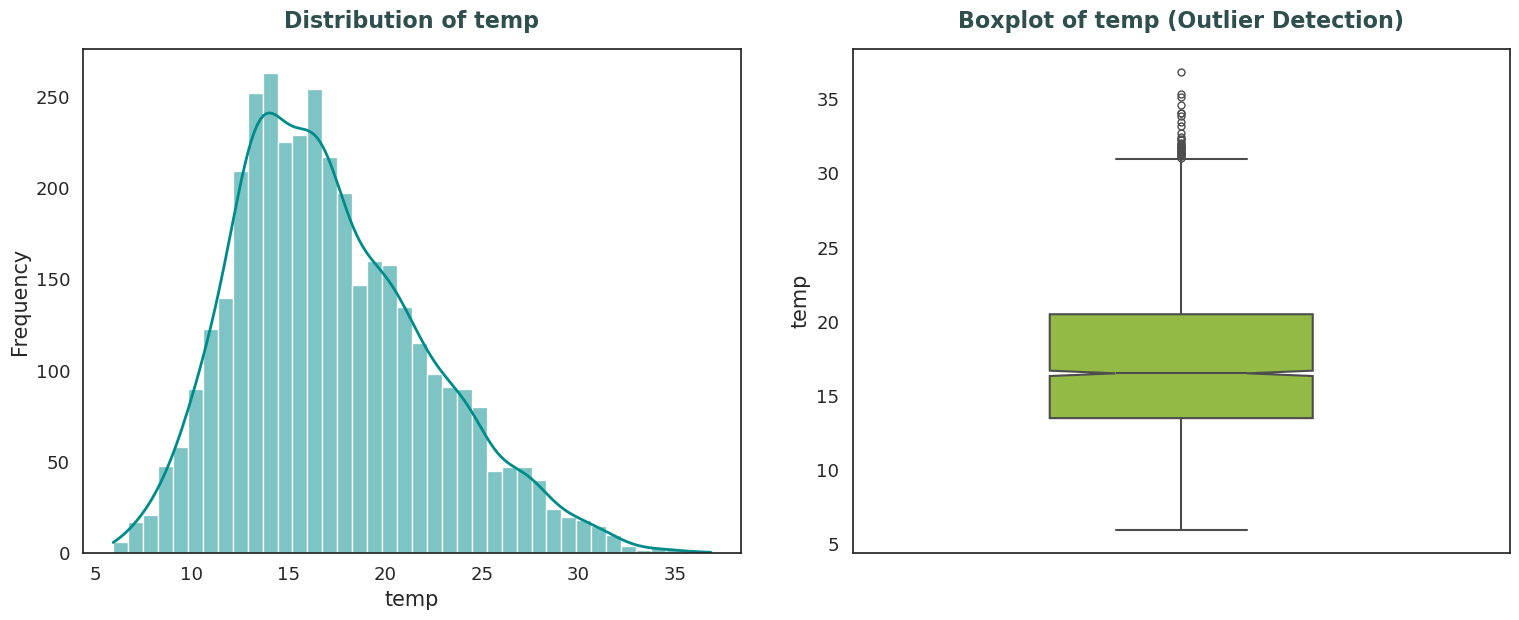

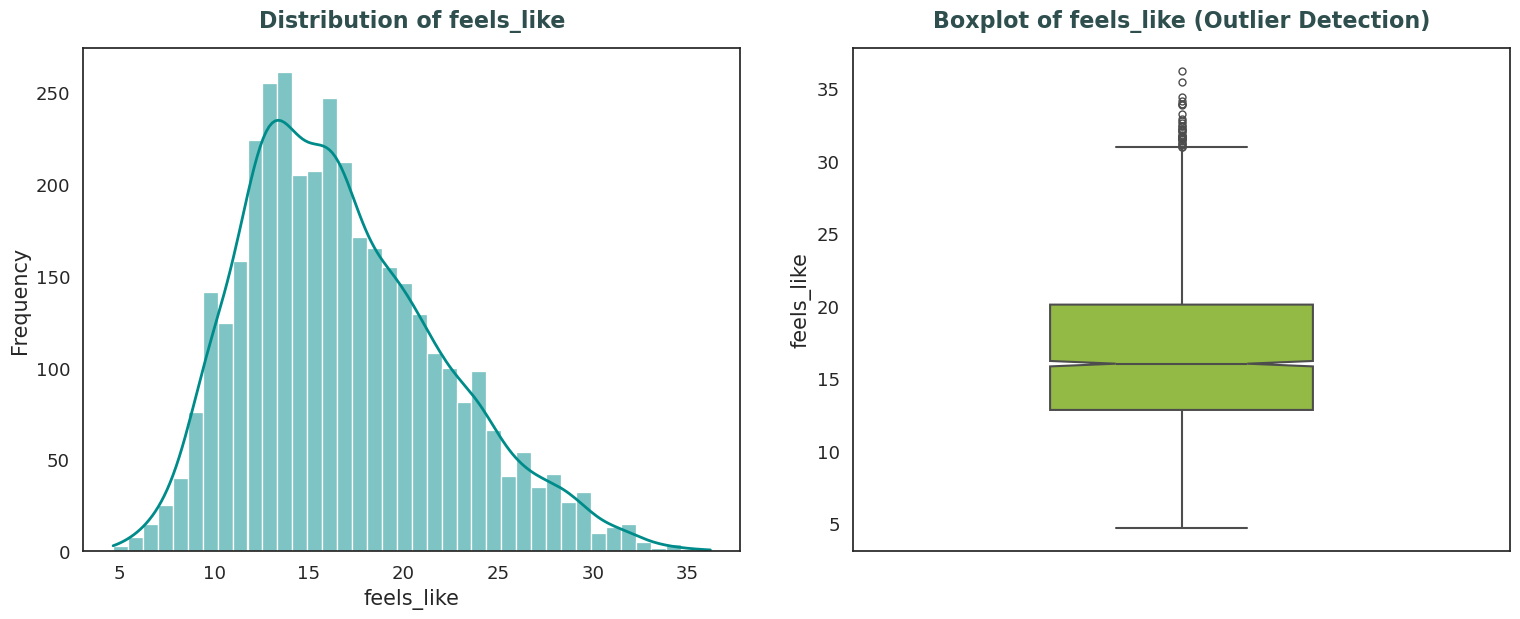

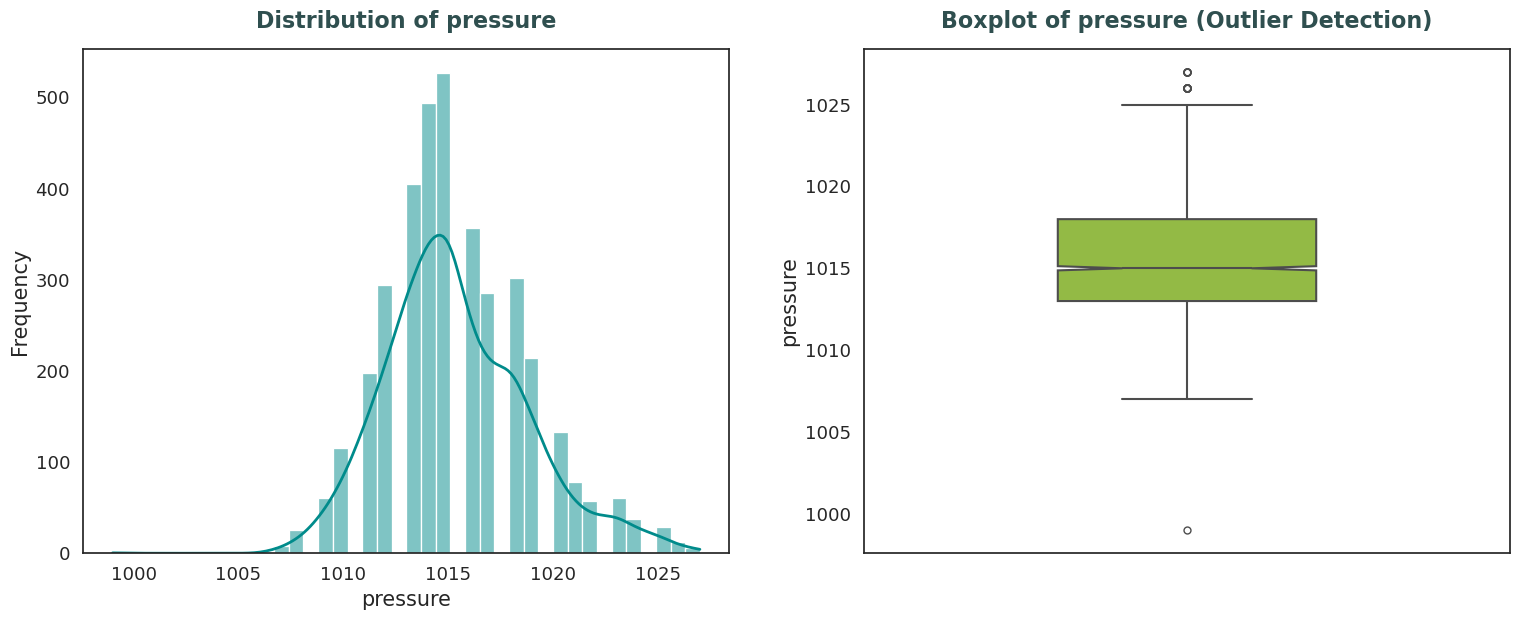

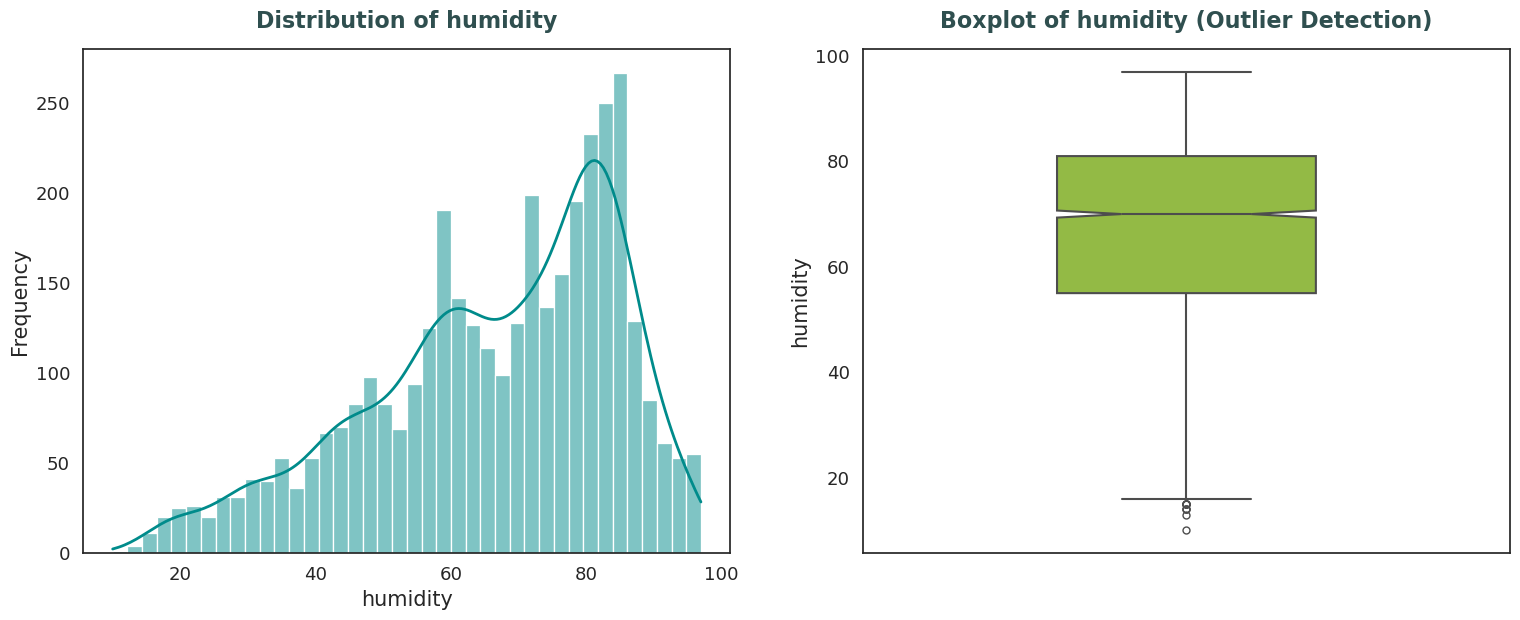

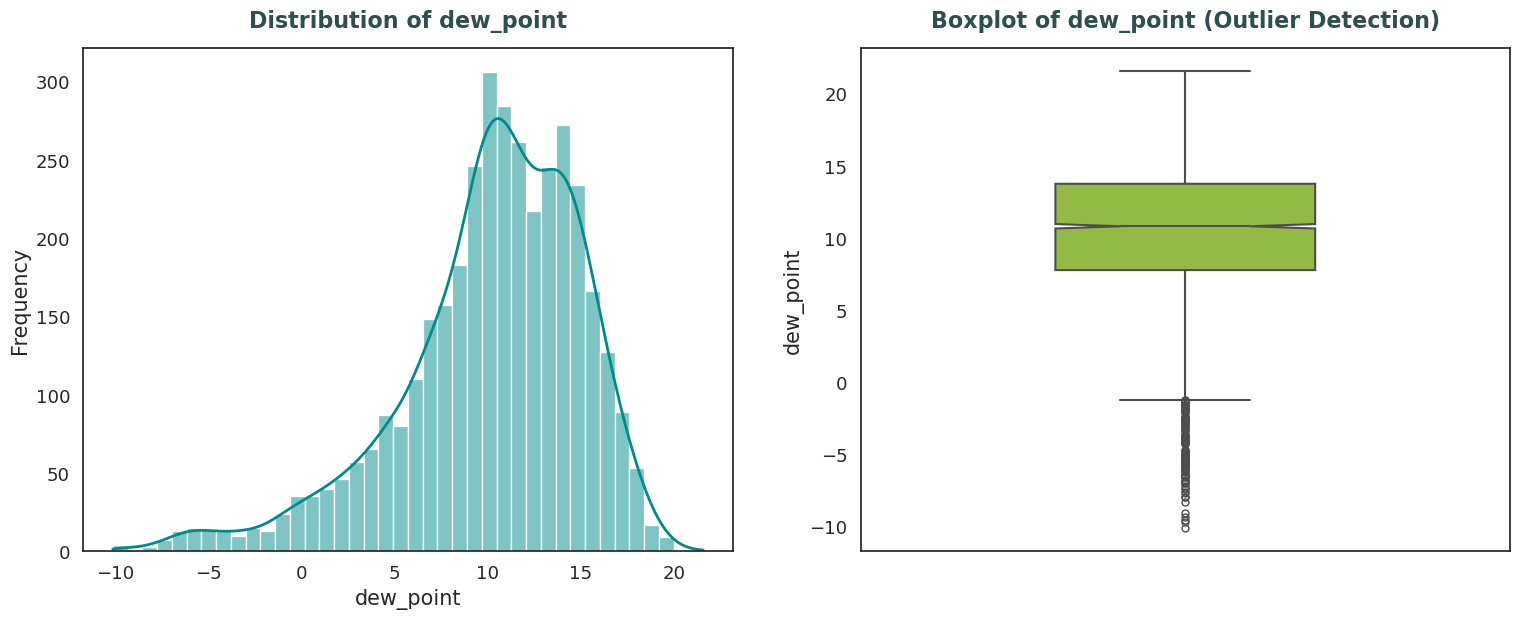

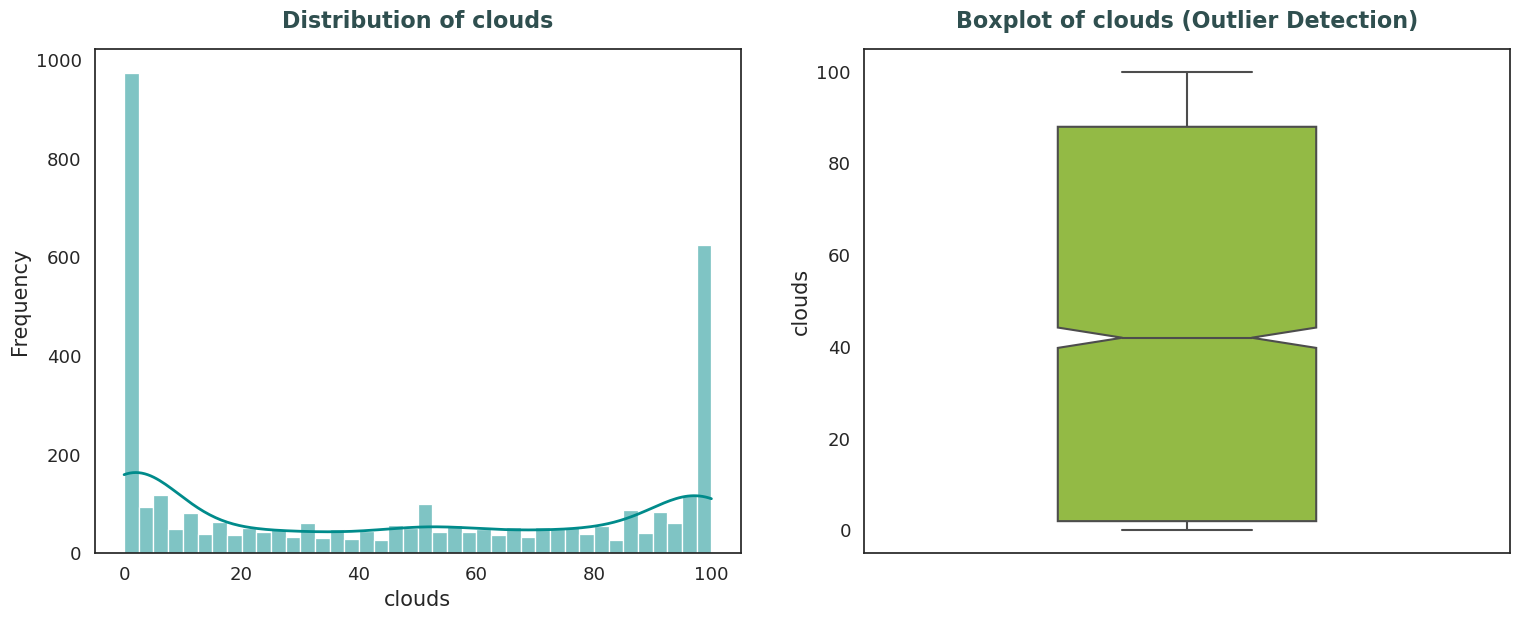

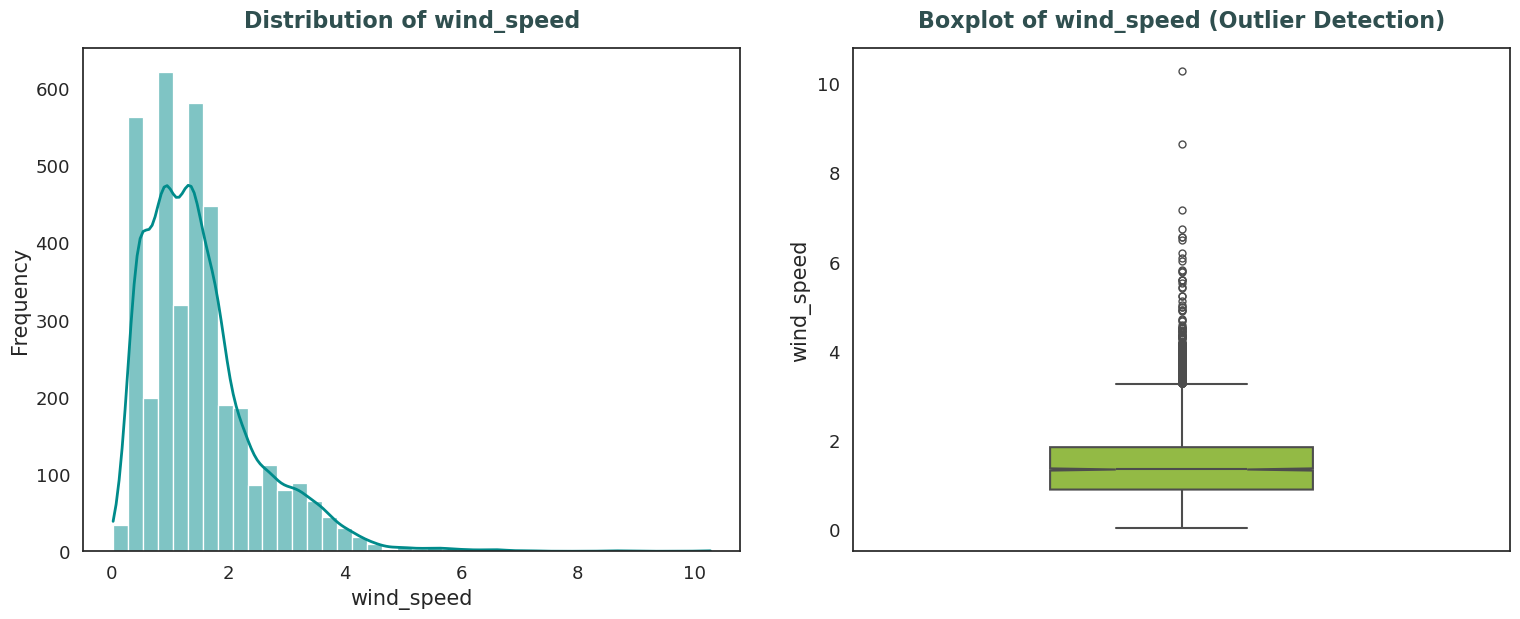

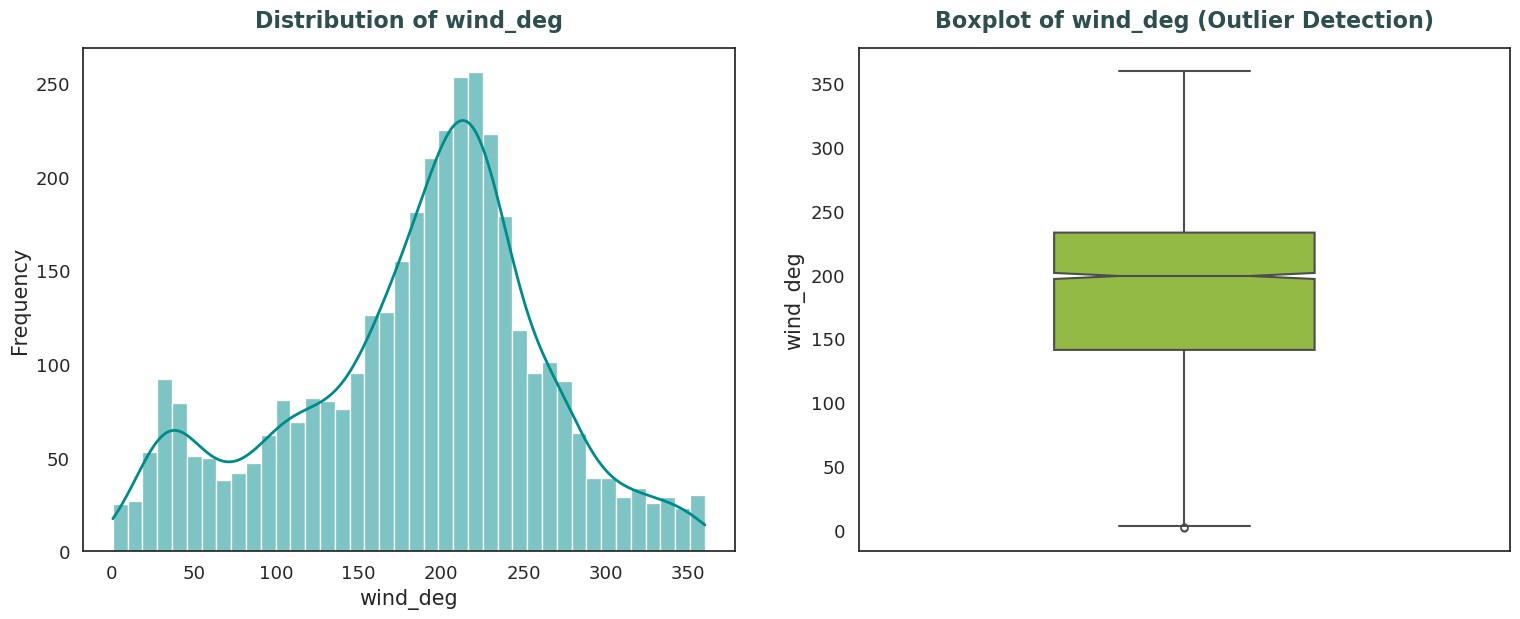

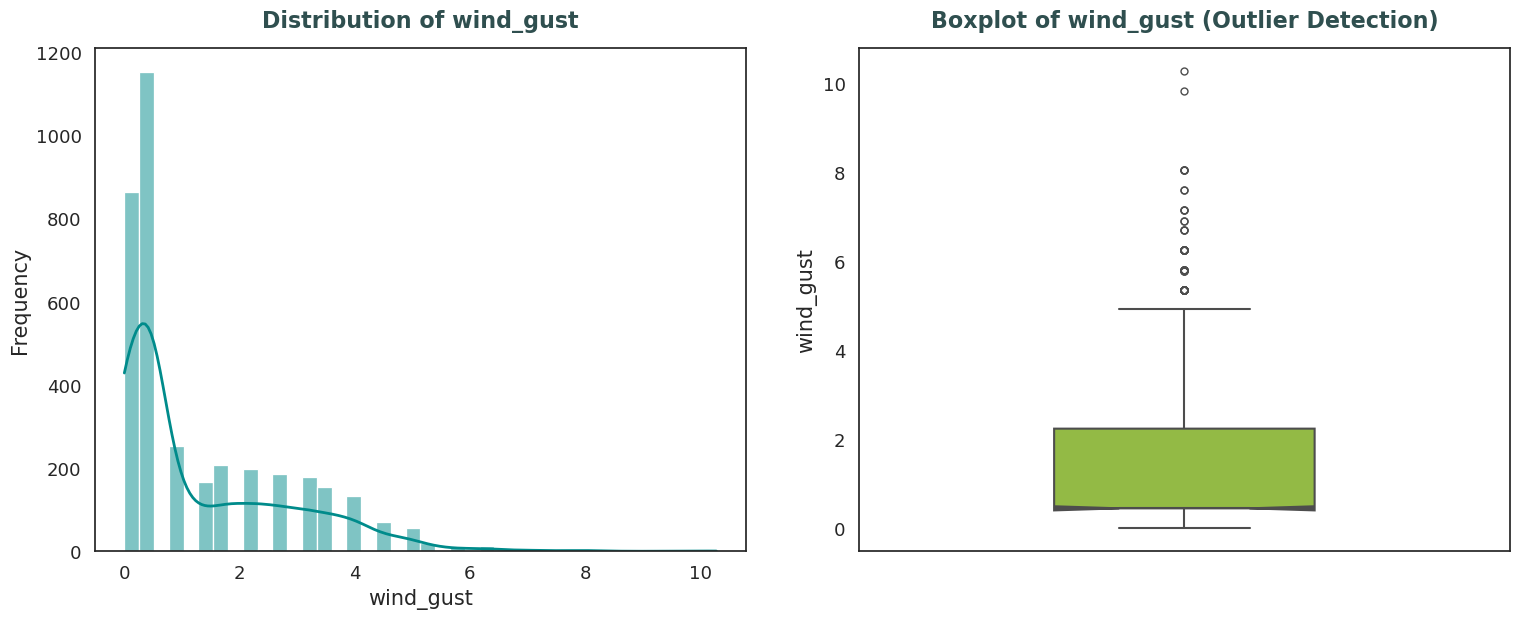

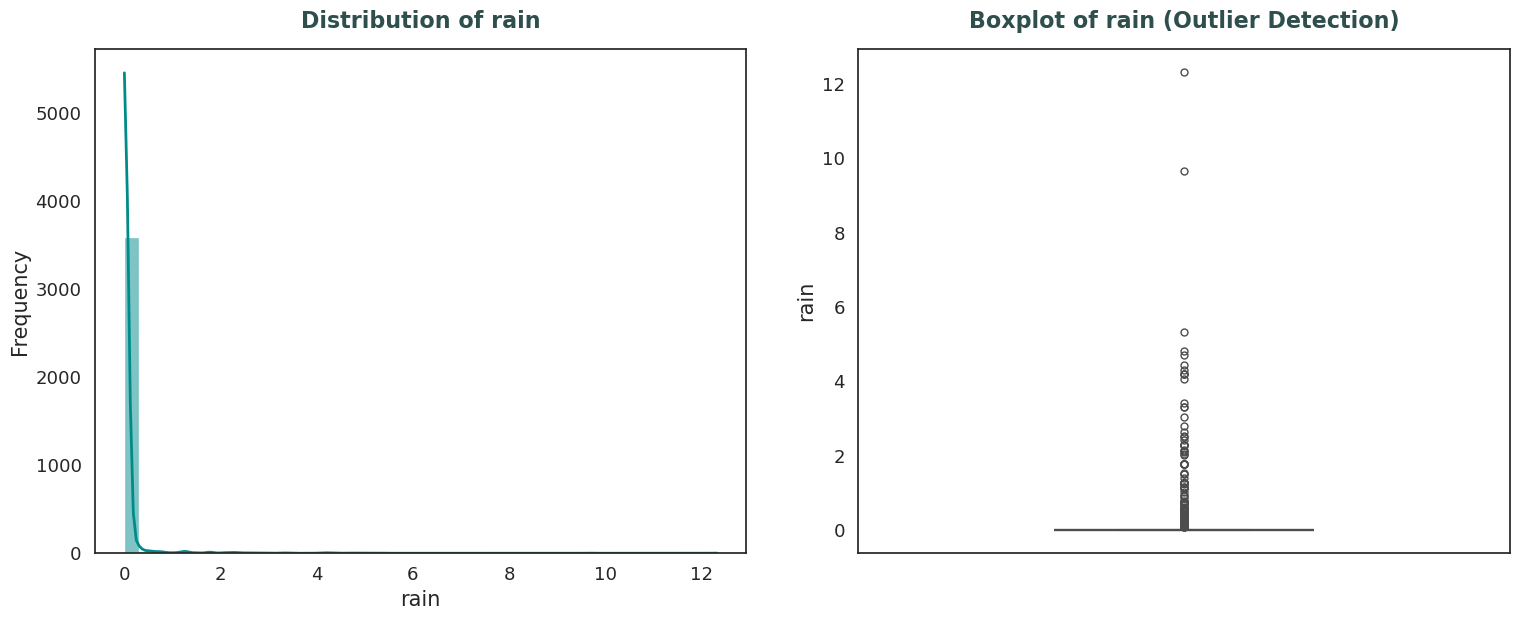

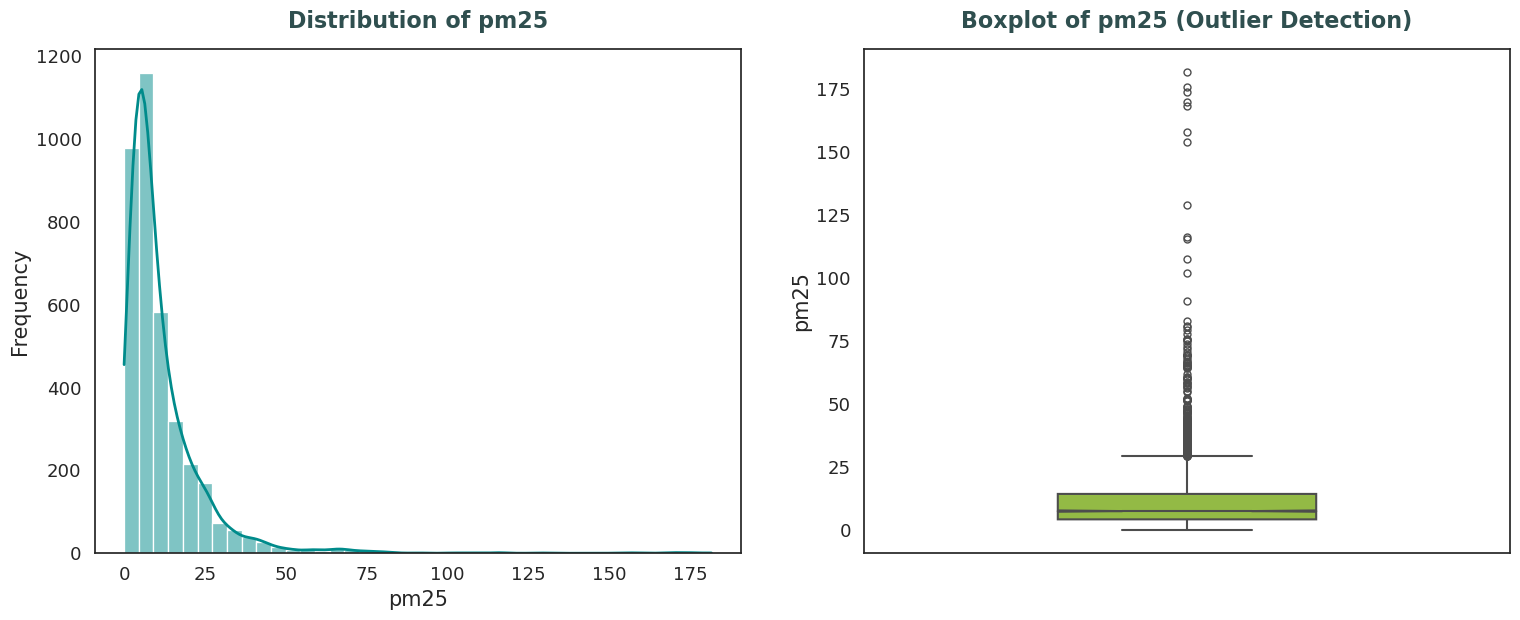

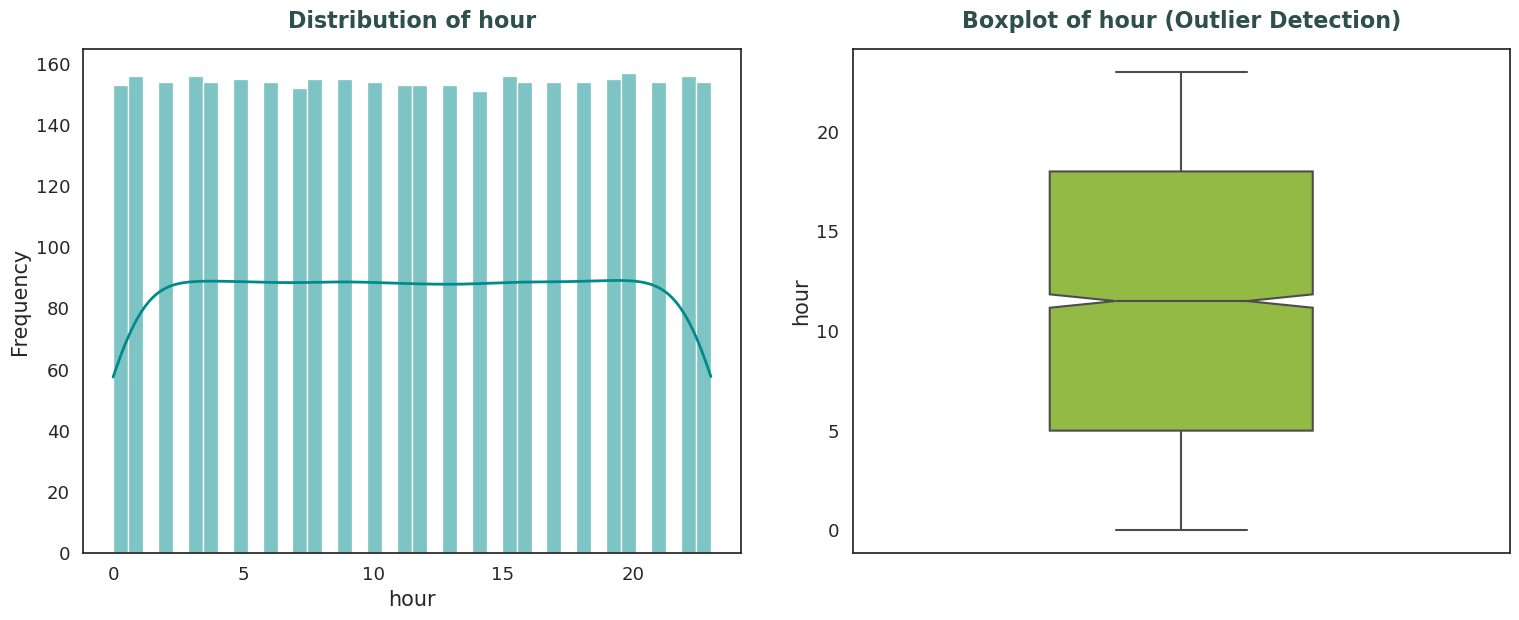

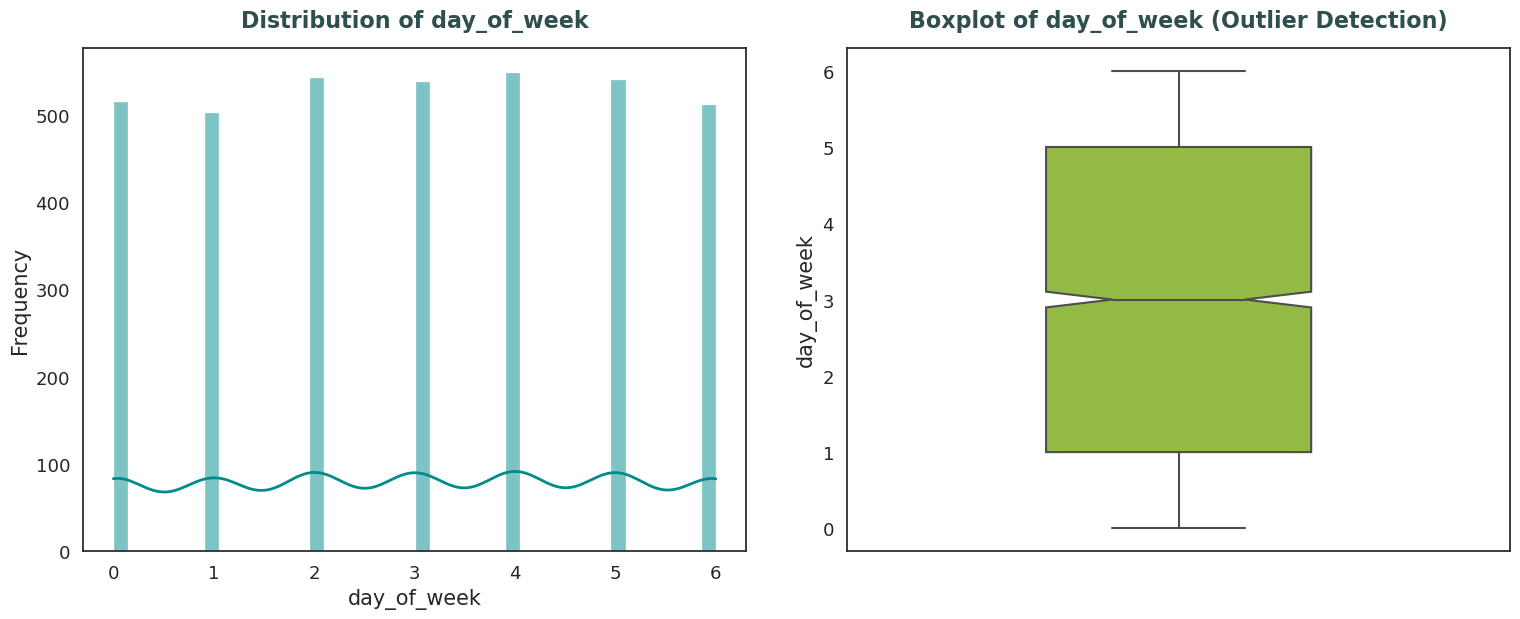

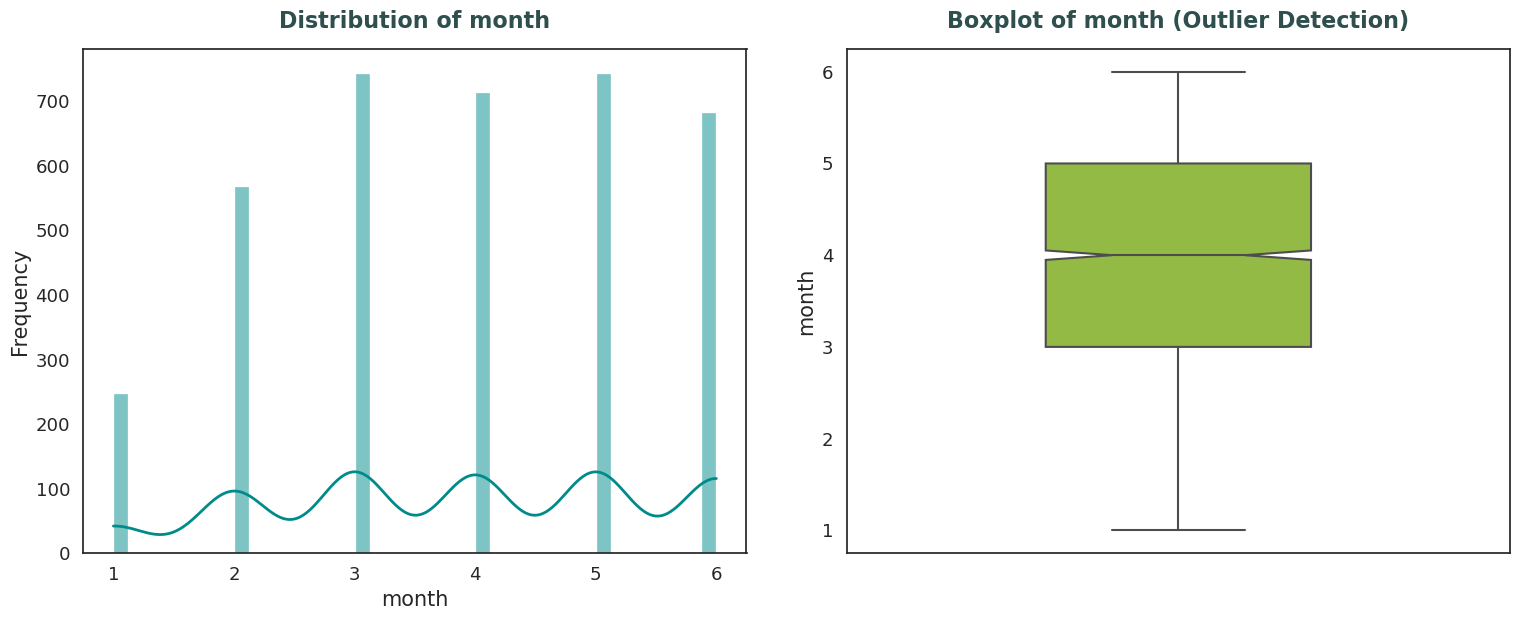

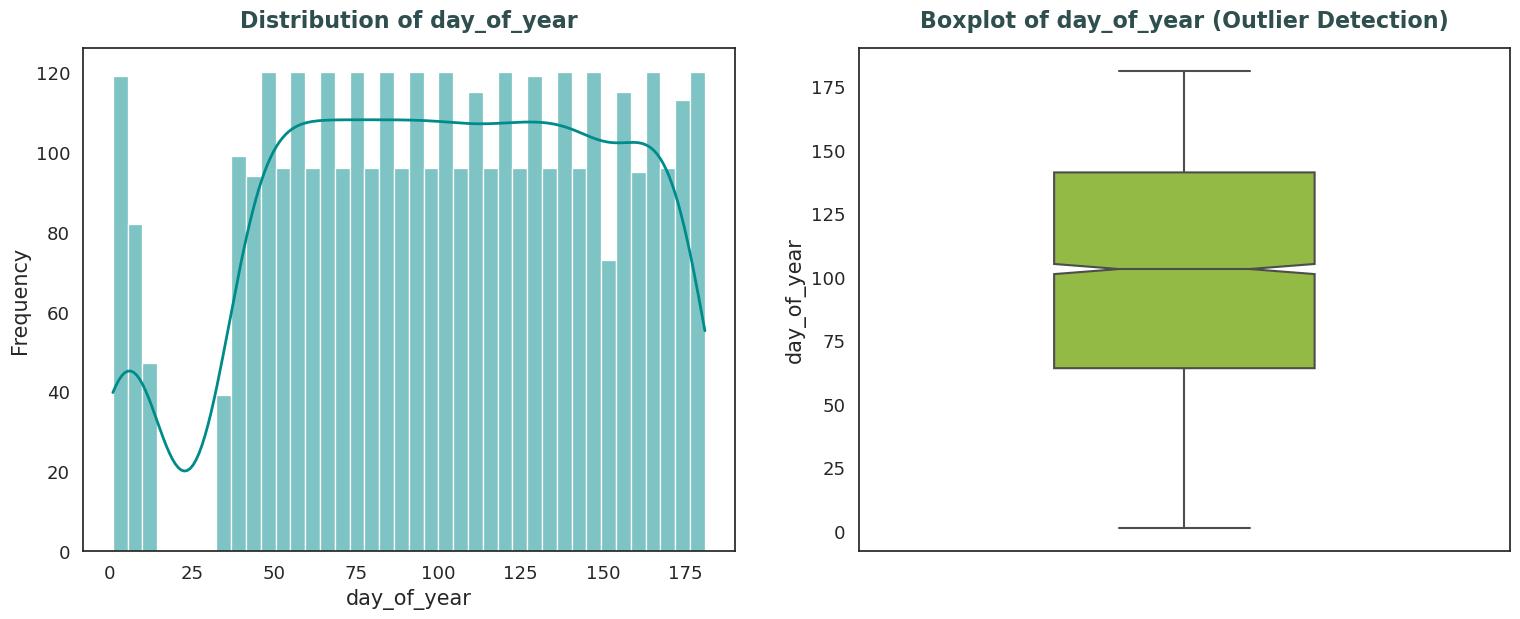

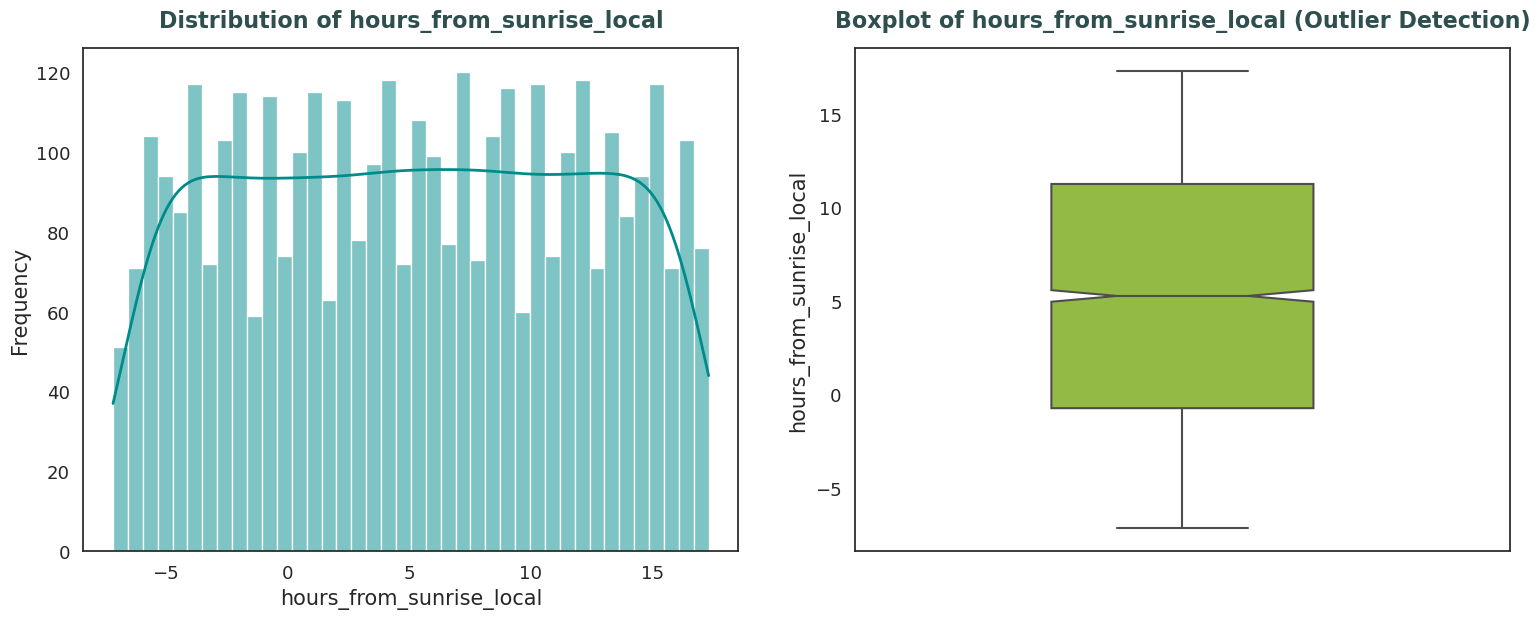

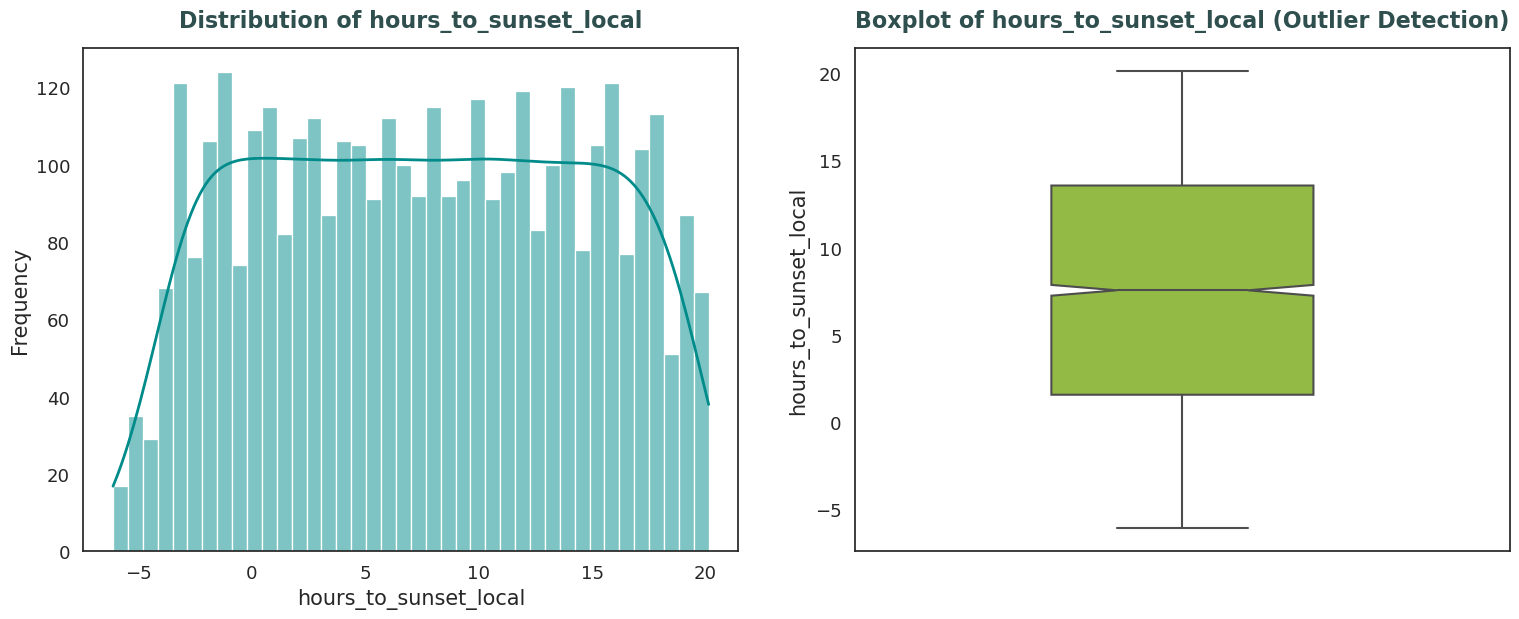

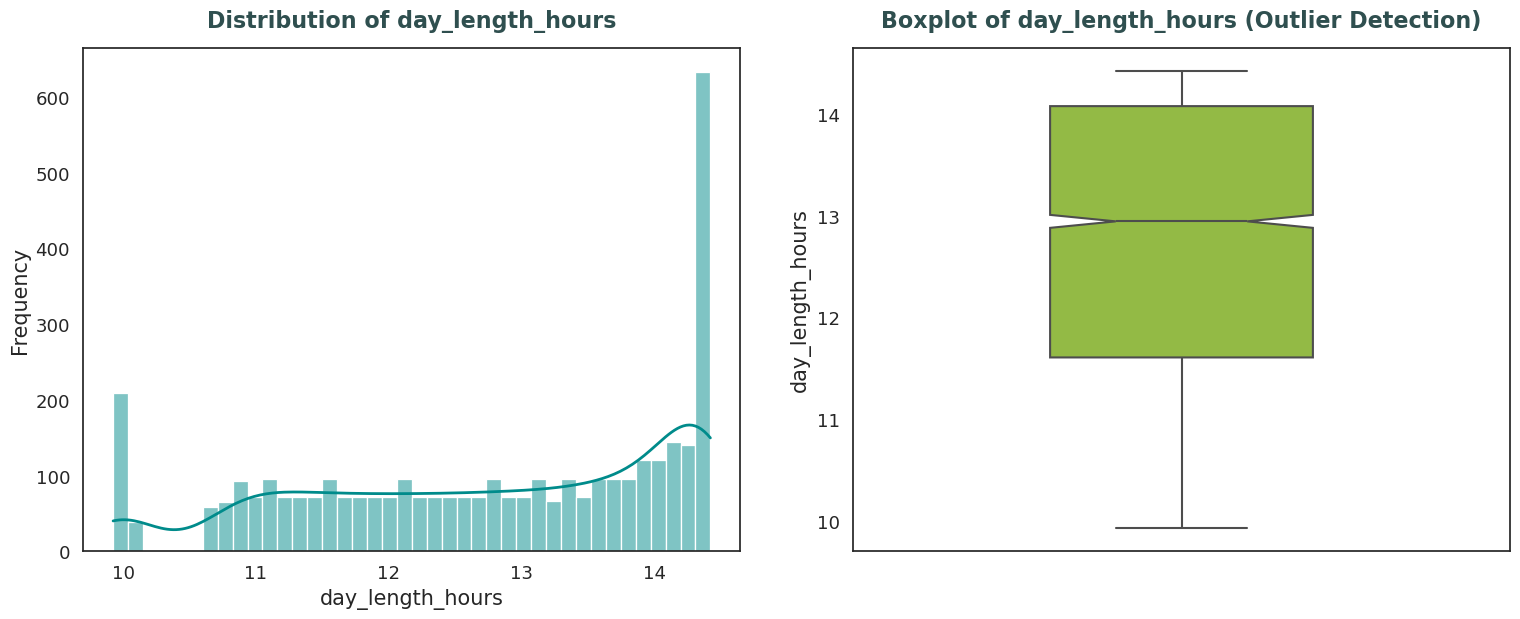

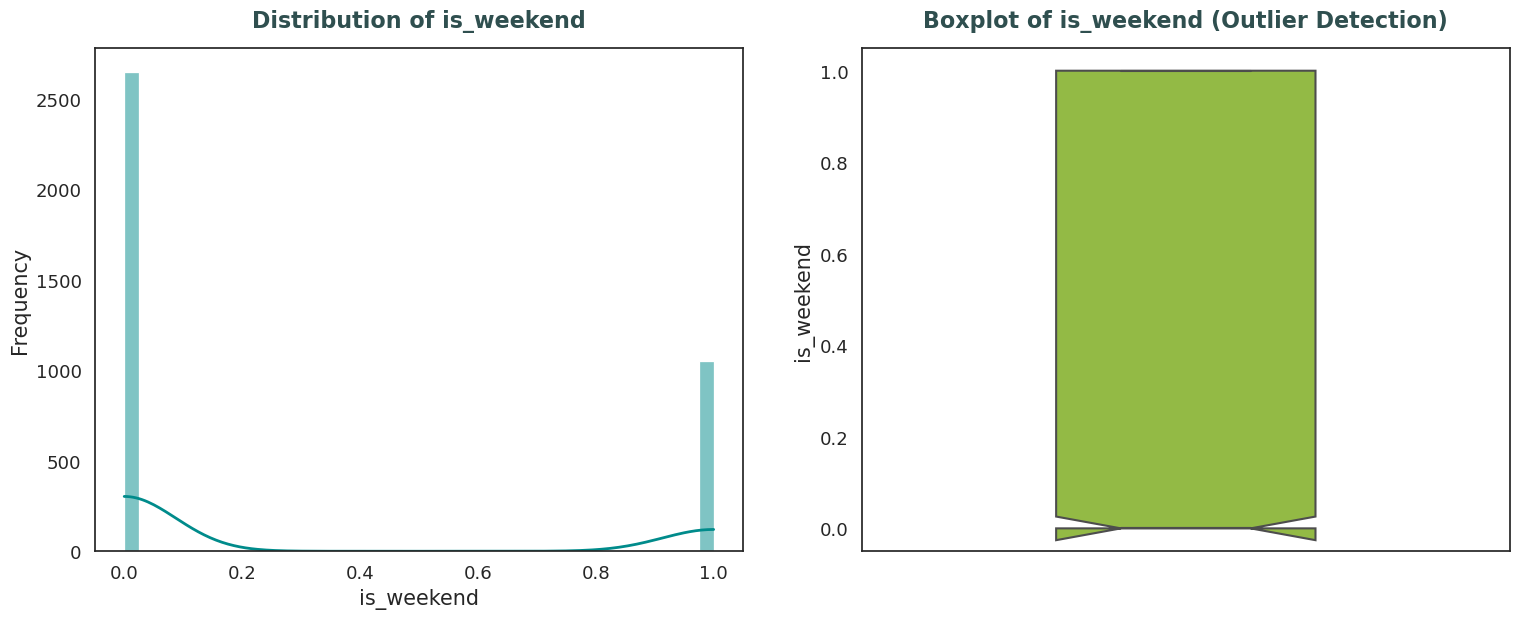

In [36]:
for col in numerical_cols:
    plt.figure(figsize=(16, 7)) # Slightly larger figure for better detail

    # Enhanced Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(combined_weather_df[col].dropna(), kde=True, bins=40, color='darkcyan', line_kws={'linewidth': 2, 'color': 'darkblue'}) # More bins, clearer KDE line
    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold', color='darkslategray', pad=15)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)

    # Enhanced Boxplot (or Violin Plot for more detail on distribution shape)
    plt.subplot(1, 2, 2)
    sns.boxplot(y=combined_weather_df[col].dropna(), color='yellowgreen', width=0.4, linewidth=1.5, fliersize=5, notch='True') # Thicker lines, smaller outlier points
    # Alternate violin plot
    # sns.violinplot(y=combined_weather_df[col].dropna(), color=custom_palette[2], inner='quartile')
    plt.title(f'Boxplot of {col} (Outlier Detection)', fontsize=16, fontweight='bold', color='darkslategray', pad=15)
    plt.ylabel(col, fontsize=15)
    plt.tick_params(axis='y', labelsize=13)

    plt.tight_layout(pad=3.0) # padding between subplots and edges
    plt.show()

__Histograms and Boxplots for All Numerical Variables (Outlier Detection)__

__PM2.5 (µg/m³):__

Histogram: The distribution of PM2.5 is highly skewed to the right (positively skewed). A large concentration of values is observed at the lower end (below 25 µg/m³), indicating that for most of the observed period, air quality was relatively good or moderate. The long tail extends towards much higher concentrations, indicating rarer but significant pollution events.

Boxplot: The boxplot clearly shows a substantial number of outliers on the higher end. The box itself is compressed at the bottom, reinforcing the right-skewness, and many individual points extend far above the upper whisker. This confirms the presence of occasional, very high PM2.5 readings that are outside the typical range.

__Temperature (temp) & Feels Like Temperature (feels_like):__

Histograms: Both temp and feels_like exhibit distributions that are roughly bell-shaped (normal-like), though perhaps slightly skewed to the left (negatively skewed), with most values concentrated in the mid-range (e.g., 15-25 for temp). This suggests that temperatures generally follow a typical pattern over the observed period.

Boxplots: For both, the boxplots show very few or no significant outliers. The whiskers extend to capture most of the data, indicating a relatively consistent temperature range without extreme deviations.

__Pressure (hPa):__

Histogram: The pressure distribution is narrow and appears almost normal or slightly skewed, with the bulk of readings concentrated around 1010-1020 hPa. This indicates atmospheric pressure remained within a fairly typical range.

Boxplot: The boxplot shows very few outliers, primarily on the lower end, suggesting occasional drops in pressure that deviate slightly from the norm, but overall, the data is quite contained.

__Humidity (%):__

Histogram: The humidity distribution is bimodal or perhaps slightly skewed to the right. There's a notable peak around 60-70% and another, smaller peak at lower humidity levels (e.g., 20-30%). This could suggest distinct atmospheric conditions present during the observed period.

Boxplot: The boxplot indicates some outliers at both the very low and very high ends of the humidity spectrum, but the majority of the data falls within a well-defined range.

__Dew Point (dew_point):__

Histogram: The dew_point distribution appears multi-modal or somewhat spread out, with concentrations at different points along the scale, suggesting varying levels of atmospheric moisture content. It's roughly centered.

Boxplot: The boxplot shows some outliers at both the lower and higher extremes, indicating periods of unusually dry or moist air.

__Clouds (%):__

Histogram: The clouds distribution is heavily skewed towards lower percentages (0-20%), indicating many periods with clear or mostly clear skies. There's another noticeable peak at very high cloud cover (80-100%), suggesting frequent full cloud cover as well. This bimodal nature is typical for cloud data.

Boxplot: The boxplot displays outliers primarily at mid-range cloud percentages that fall outside the main clusters of very low or very high cloud cover.

__Wind Speed (m/s) & Wind Gust (m/s):__

Histograms: Both wind_speed and wind_gust are highly skewed to the right, with the vast majority of readings indicating low wind conditions (0-5 m/s). There's a long tail extending to higher speeds, representing rare occurrences of strong winds or gusts.

Boxplots: Both boxplots show a significant number of outliers on the higher end, reflecting the occasional strong wind events that are uncommon compared to the usual calmer conditions. This is expected for wind data.

__Rain (mm):__

Histogram: The rain distribution is extremely skewed to the right, with an overwhelming majority of observations at 0 mm (no rain). The tiny bar extending to higher values indicates that rainfall events are rare but can occur.

Boxplot: The boxplot confirms this by showing numerous outliers representing the few instances where rainfall actually occurred. The box and lower whisker are compressed at zero, as most of the data is concentrated there.

__Hour (0-23):__

Histogram: The hour distribution appears relatively uniform, with similar frequencies for most hours of the day. This is expected for hourly data collected over an extended period.

Boxplot: The boxplot shows no outliers, as expected for a cyclic categorical-like variable.

__Day of Week (0-6):__

Histogram: The day_of_week histogram shows a fairly even distribution across all days (0-6), implying that data was collected consistently throughout the week.

Boxplot: As expected for a categorical variable, the boxplot shows no outliers.

__Month (1-12):__

Histogram: The month histogram shows a uniform distribution across months 1-6 (January to June), indicating consistent data collection over this period.

Boxplot: No outliers are present, which is typical for such a variable.

__Day of Year (1-366):__

Histogram: The day_of_year histogram shows a uniform distribution across the observed days of the year, as expected from a continuous six-month data collection.

Boxplot: No outliers are present.

__Hours From Sunrise Local & Hours To Sunset Local:__

Histograms: Both hours_from_sunrise_local and hours_to_sunset_local have multi-modal distributions that are somewhat spread out. There are peaks at various points, reflecting the distribution of hours relative to sunrise and sunset throughout the day.

Boxplots: Both show some outliers at their extremes, indicating occasional unusual durations before/after sunrise/sunset (perhaps due to data edge cases or specific times of year).

__Day Length Hours:__

Histogram: The day_length_hours histogram shows a somewhat uniform or slightly increasing distribution from around 10-14 hours. This reflects the natural increase in daylight hours from January to June.

Boxplot: The boxplot shows no significant outliers, as day length changes predictably.

__Summary for Outlier Detection:__

Target Variable (pm25), Wind Features (wind_speed, wind_gust), and rain show a significant number of high-end outliers due to their inherently skewed nature (frequent low values, rare high values). These outliers represent real-world events (pollution spikes, strong winds, rain events) rather than errors and are important for forecasting.

Other variables like temp, feels_like, pressure, hour, day_of_week, month, and day_of_year are relatively clean with few to no outliers, indicating stable and expected distributions.

humidity, dew_point, clouds, hours_from_sunrise_local, and hours_to_sunset_local show some outliers at both ends, suggesting periods of extreme conditions (very dry/humid, very clear/cloudy skies) that are less common but still within a plausible range for these variables.

Understanding these distributions and the nature of outliers is crucial for feature engineering (e.g., handling skewed data for some models) and for interpreting model performance.

## PM2.5 and its Relationships

__PM2.5 Time Series Plot (Overview of Trends)__

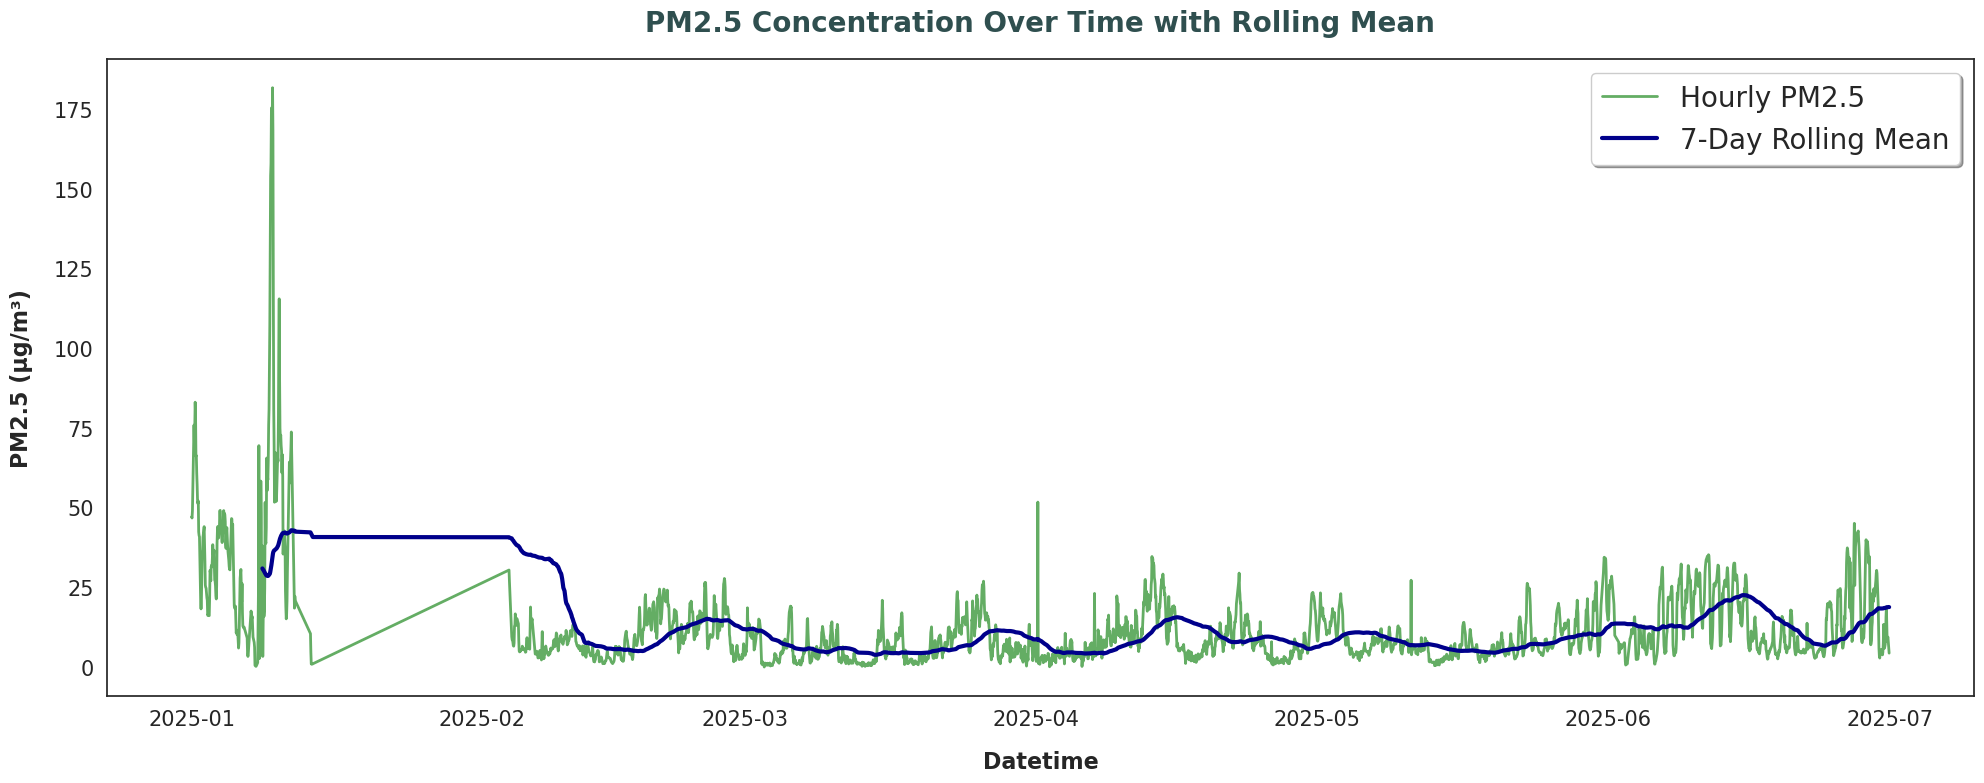

In [37]:
plt.figure(figsize=(20, 8)) # Larger figure for time series detail
sns.lineplot(x=combined_weather_df.index, y=combined_weather_df['pm25'], color='forestgreen', linewidth=2, alpha=0.7, label='Hourly PM2.5')
# Add a rolling mean to highlight trends
sns.lineplot(x=combined_weather_df.index, y=combined_weather_df['pm25'].rolling(window=24*7).mean(), # 7-day rolling mean
             color='darkblue', linewidth=3, label='7-Day Rolling Mean')

plt.title('PM2.5 Concentration Over Time with Rolling Mean', fontsize=20, fontweight='bold', color='darkslategray', pad=20)
plt.xlabel('Datetime', fontsize=16, weight='bold', labelpad=15)
plt.ylabel('PM2.5 (µg/m³)', fontsize=16, weight='bold', labelpad=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

The "PM2.5 Concentration Over Time with Rolling Mean" plot (Page 1 of eda.pdf) provides a high-level overview of PM2.5 concentrations over the observed six-month period, highlighting both hourly fluctuations and underlying longer-term trends.

- Overall Trend and Variability: The "Hourly PM2.5" line (light green/blue) shows significant short-term variability and volatility in PM2.5 concentrations. There are numerous sharp spikes, indicating brief periods of elevated pollution, interspersed with periods of much lower concentrations. This rapid fluctuation is typical for air quality data, which can be influenced by hourly changes in emissions, weather, and atmospheric conditions.

- Dominant Initial Peak (January): The most striking feature of the plot is the very high peak in PM2.5 concentrations occurring in January 2025. This period shows multiple instances where PM2.5 levels exceed 150 µg/m³, which are significantly higher than the rest of the observed period. This initial surge suggests a period of severe air quality events, likely driven by specific meteorological conditions or emission patterns during that winter month.

- 7-Day Rolling Mean: The "7-Day Rolling Mean" (dark blue line) effectively smooths out the hourly fluctuations, revealing the underlying longer-term trends. After the high peak in January, the rolling mean shows a sharp decline in February and March, indicating a significant improvement in overall air quality. From late March through June, the 7-day rolling mean remains relatively stable and low, generally hovering below 25 µg/m³. This suggests that while hourly spikes still occur, the sustained, average pollution levels are much lower in the latter part of the dataset.

- Seasonal Influence: The visual evidence from the rolling mean strongly supports a seasonal pattern, with significantly higher average pollution levels in the earlier (winter) months of the dataset (January-February) compared to the later (spring/early summer) months (April-June). This aligns with common knowledge about air quality, where winter months can often see worse pollution due to factors like temperature inversions and increased heating.

In summary, the time series plot illustrates that PM2.5 in the dataset is highly dynamic hourly, experiences significant high-pollution events (especially early in the period), and exhibits clear seasonal trends with a general improvement in air quality from winter into spring/early summer.

__PM2.5 by Hour of Day__

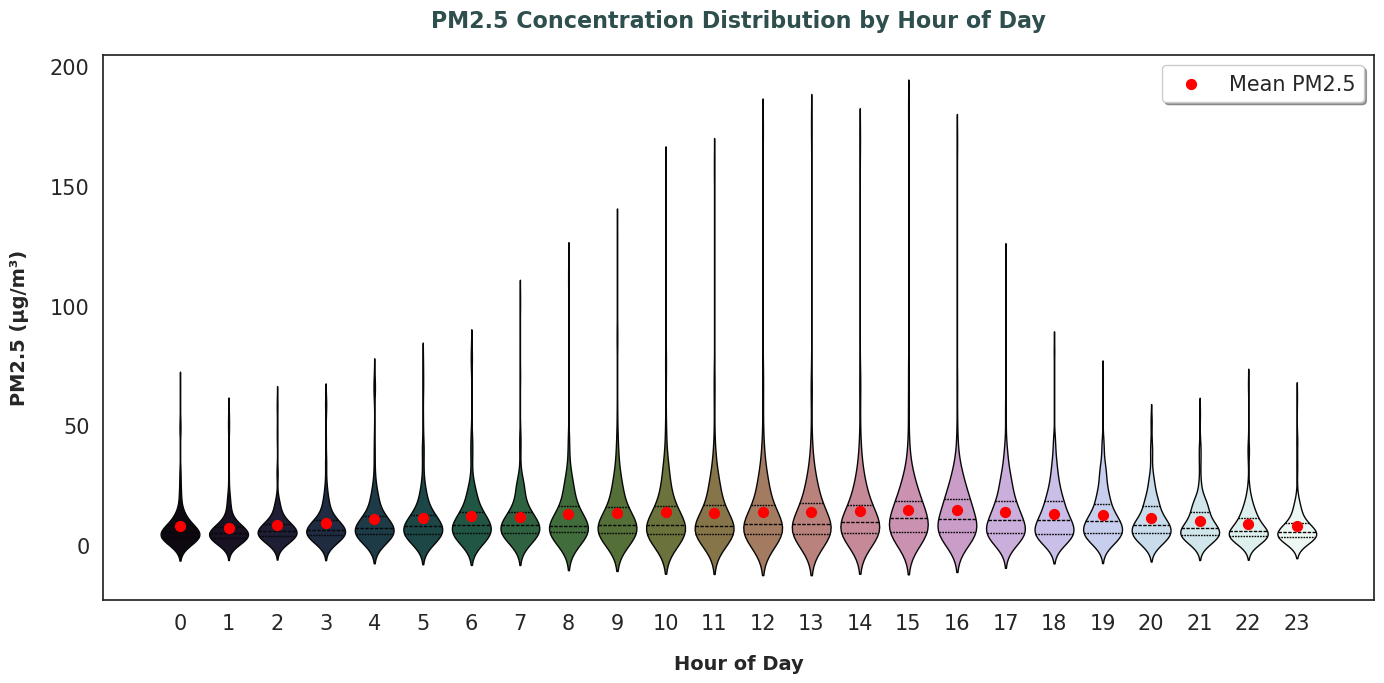

In [38]:
plt.figure(figsize=(14, 7))
sns.violinplot(x='hour', y='pm25', data=combined_weather_df, palette='cubehelix', inner='quartile', linewidth=1)
mean_pm25_hour = combined_weather_df.groupby('hour')['pm25'].mean()
plt.scatter(x=mean_pm25_hour.index, y=mean_pm25_hour.values, color='red', s=50, zorder=3, label='Mean PM2.5')
plt.title('PM2.5 Concentration Distribution by Hour of Day', fontsize=16, fontweight='bold', color='darkslategray', pad=20) 
plt.xlabel('Hour of Day', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(fontsize=15, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

The violin plot clearly illustrates a strong diurnal (daily) pattern in PM2.5 concentrations.

Peaks: PM2.5 levels are generally higher during the early morning hours (around 6-9 AM) and again in the late evening/night (approximately 6 PM - 1 AM). The violins are wider and the mean PM2.5 (red dots) is higher during these periods. This is a common pattern often associated with morning and evening rush hour traffic and atmospheric inversions that trap pollutants close to the ground during cooler, calmer night-time conditions.

Lows: Concentrations tend to be lower during midday (around 10 AM - 4 PM), likely due to increased atmospheric mixing and photochemical dispersion under warmer, sunnier conditions.

__PM2.5 by Day of Week__

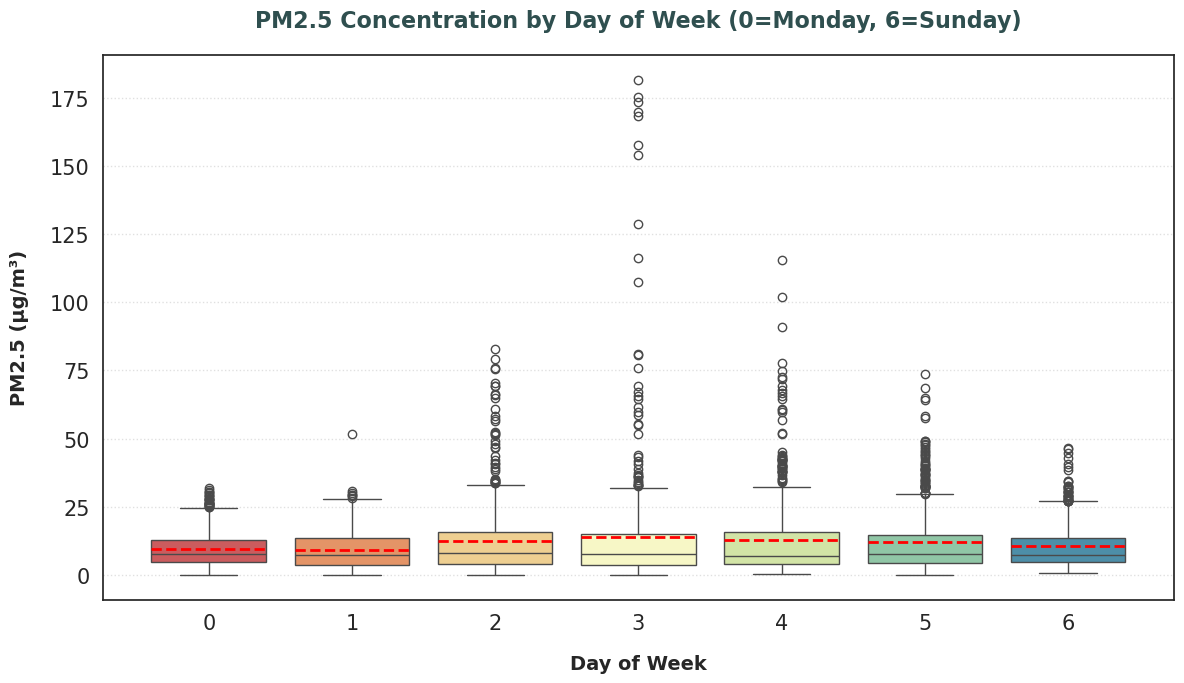

In [39]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='day_of_week', y='pm25', data=combined_weather_df, palette='Spectral', order=[0, 1, 2, 3, 4, 5, 6])
mean_pm25_dow = combined_weather_df.groupby('day_of_week')['pm25'].mean()
for i, dow_mean in enumerate(mean_pm25_dow.values):
    plt.hlines(dow_mean, i - 0.4, i + 0.4, color='red', linestyle='--', linewidth=2, zorder=3)
plt.title('PM2.5 Concentration by Day of Week (0=Monday, 6=Sunday)', fontsize=16, fontweight='bold', color='darkslategray', pad=20) 
plt.xlabel('Day of Week', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15) 
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

The box plot, with days 0 (Monday) through 6 (Sunday), reveals a discernible weekly pattern.

Weekdays vs. Weekends: PM2.5 concentrations, both median and mean (red dashed line), appear slightly higher on weekdays (especially days 2, 3, 4 - Wednesday, Thursday, Friday) compared to weekends (days 5 and 6 - Saturday and Sunday). This suggests that reduced human activity, such as less commuter traffic and industrial operations, contributes to slightly cleaner air during the weekend.

Outliers: All days show significant outliers, indicating occasional high pollution events that deviate from the typical patterns.

__PM2.5 by Month__

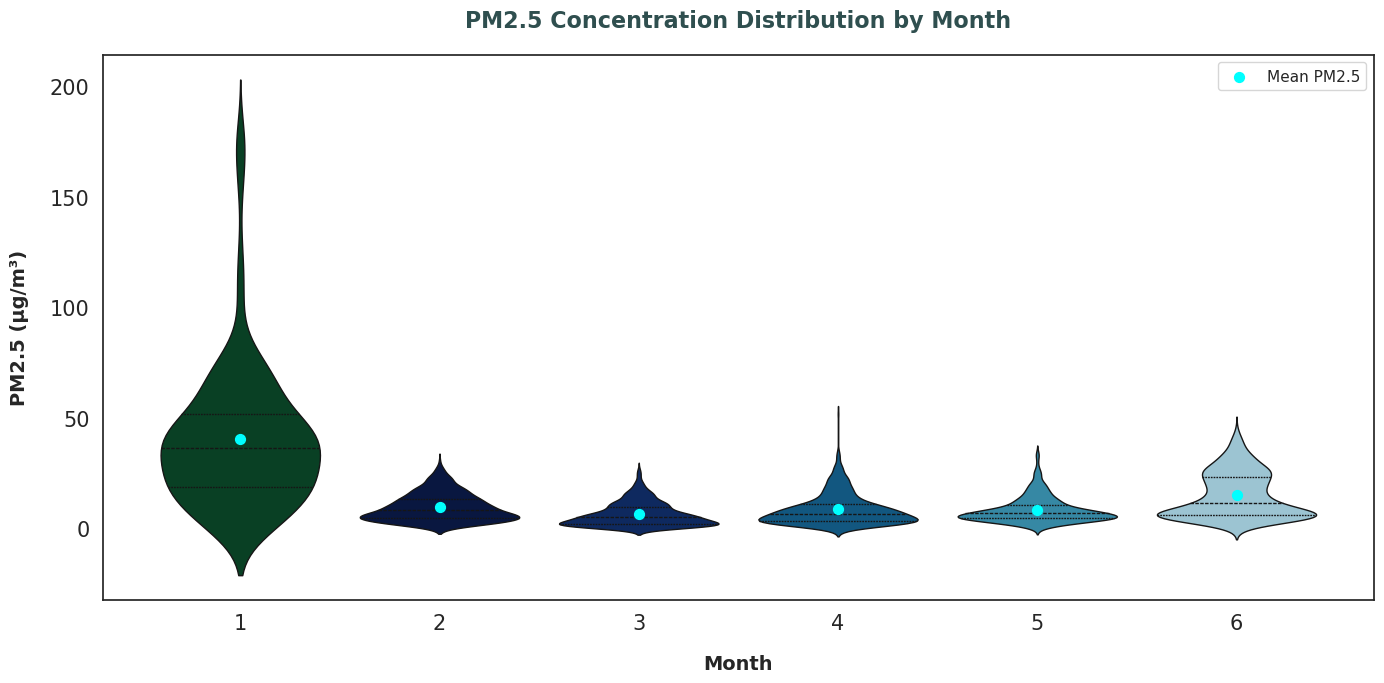

In [40]:
plt.figure(figsize=(14, 7))
sns.violinplot(x='month', y='pm25', data=combined_weather_df, palette='ocean', inner='quartile', linewidth=1)
mean_pm25_month = combined_weather_df.groupby('month')['pm25'].mean()
plt.scatter(x=mean_pm25_month.index - 1, y=mean_pm25_month.values, color='cyan', s=50, zorder=3, label='Mean PM2.5')
plt.title('PM2.5 Concentration Distribution by Month', fontsize=16, fontweight='bold', color='darkslategray', pad=20) 
plt.xlabel('Month', fontsize=14, weight='bold', labelpad=15) 
plt.ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15) 
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend()
plt.tight_layout()
plt.show()

The violin plot for monthly variation (months 1-6) shows a clear seasonal influence.

Highest in January: Month 1 (January) stands out with significantly higher PM2.5 concentrations (both mean and overall distribution) compared to all other months. The violin is much wider and extends to much higher values, indicating more frequent and severe pollution events.

Decreasing Trend: There's a general decreasing trend in average PM2.5 from January to June, with months 2 through 6 showing consistently lower and less variable concentrations. This aligns with typical seasonal patterns where winter months often experience higher pollution due to specific meteorological conditions (e.g., inversions) and potentially increased heating emissions.

__PM2.5 During Daylight vs. Nighttime__

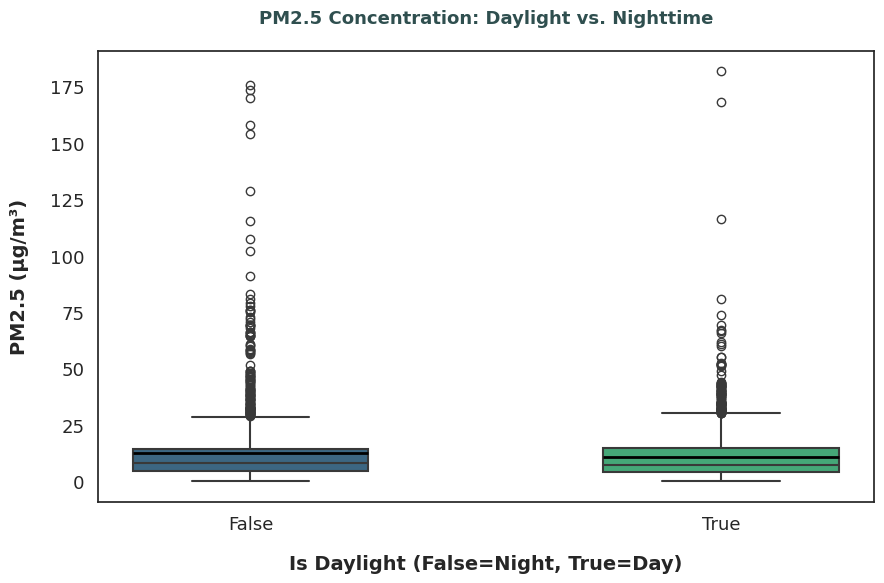

In [41]:
plt.figure(figsize=(9, 6))
sns.boxplot(x='is_daylight', y='pm25', data=combined_weather_df, palette='viridis', linewidth=1.5, width=0.5)
mean_pm25_daylight = combined_weather_df.groupby('is_daylight')['pm25'].mean()
for i, val in enumerate(mean_pm25_daylight.values):
    plt.hlines(val, i - 0.25, i + 0.25, color='black', linestyle='-', linewidth=2, zorder=3)
plt.title('PM2.5 Concentration: Daylight vs. Nighttime', fontsize=13, fontweight='bold', color='darkslategray', pad=20) 
plt.xlabel('Is Daylight (False=Night, True=Day)', fontsize=14, weight='bold', labelpad=15) 
plt.ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15) 
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.tight_layout()
plt.show()

This box plot compares PM2.5 levels when is_daylight is False (Night) versus True (Day).

Higher at Night: PM2.5 concentrations are clearly higher during nighttime hours (False) compared to daylight hours (True). Both the median and the interquartile range are elevated for the 'False' category. This observation is consistent with reduced atmospheric mixing (stagnant air) and less photochemical activity during the night, which allows pollutants to accumulate.

## PM2.5 vs. Continuous Weather Variables (Correlation Insights)_

In [42]:
# Select relevant continuous weather columns
weather_numeric_cols = [
    'temp', 'feels_like', 'pressure', 'humidity', 'dew_point',
    'wind_speed', 'wind_gust', 'rain', 'clouds',
    'hours_from_sunrise_local', 'hours_to_sunset_local', 'day_length_hours'
]

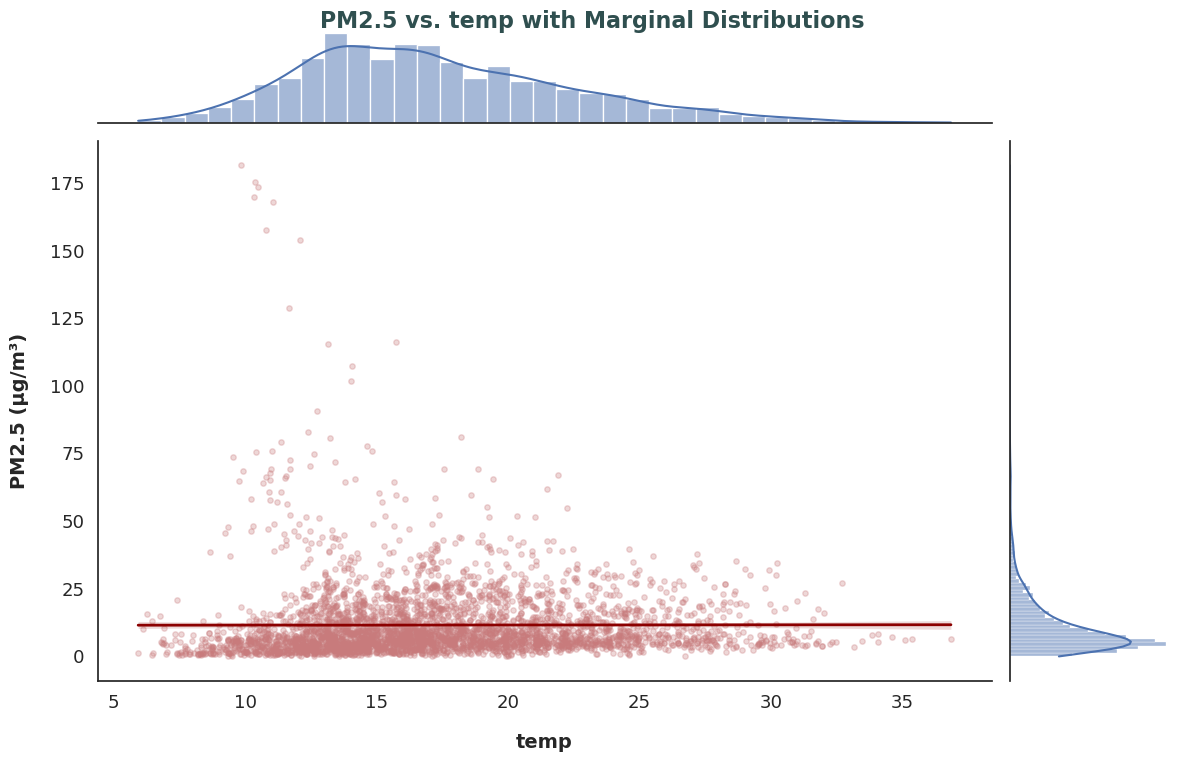

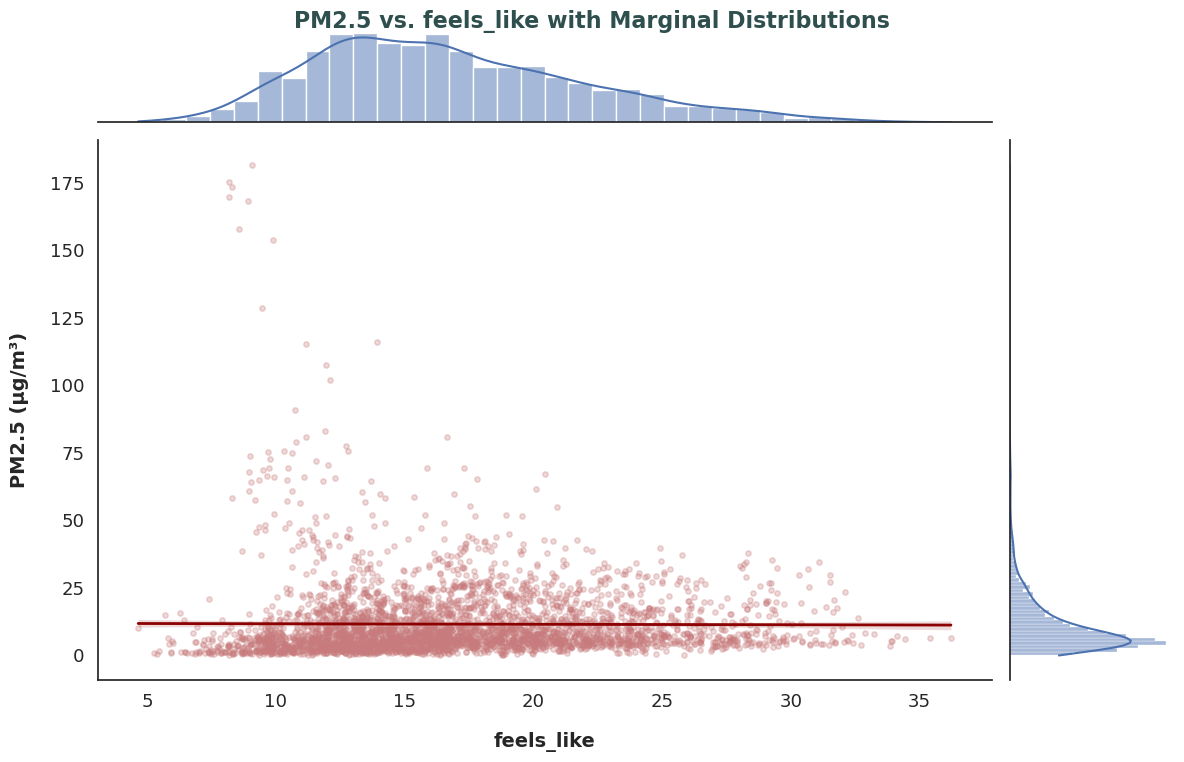

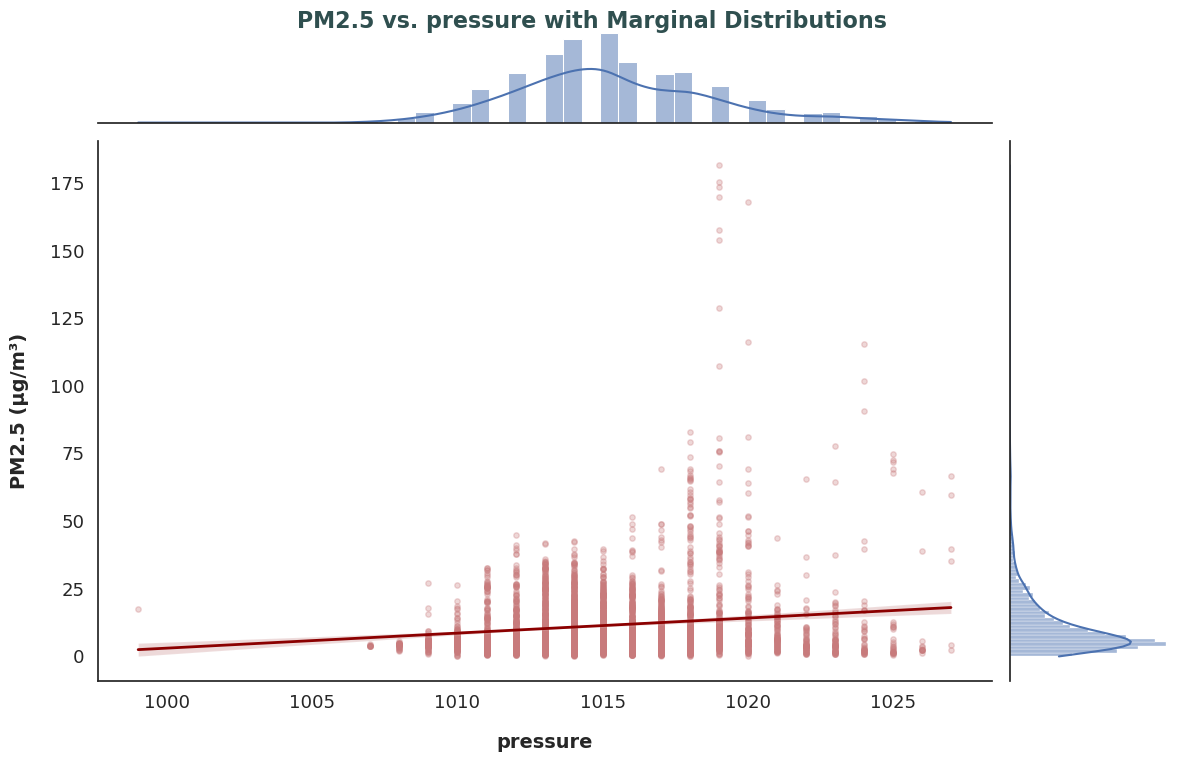

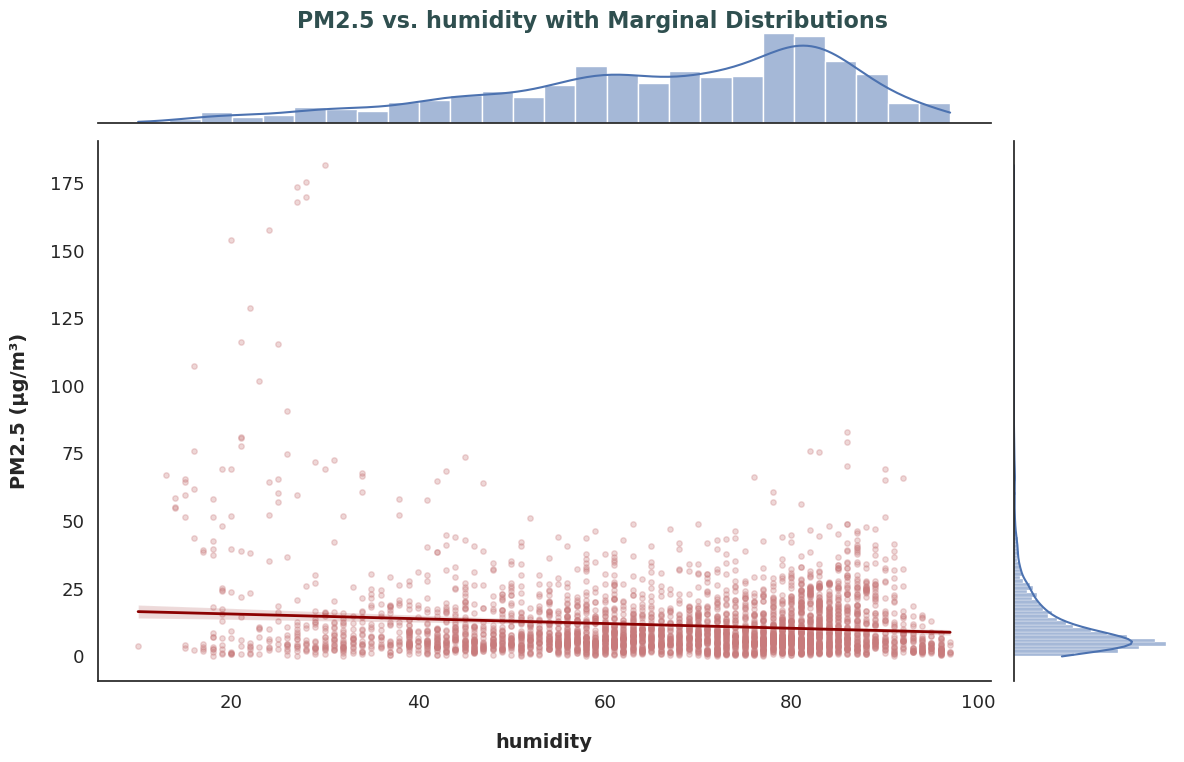

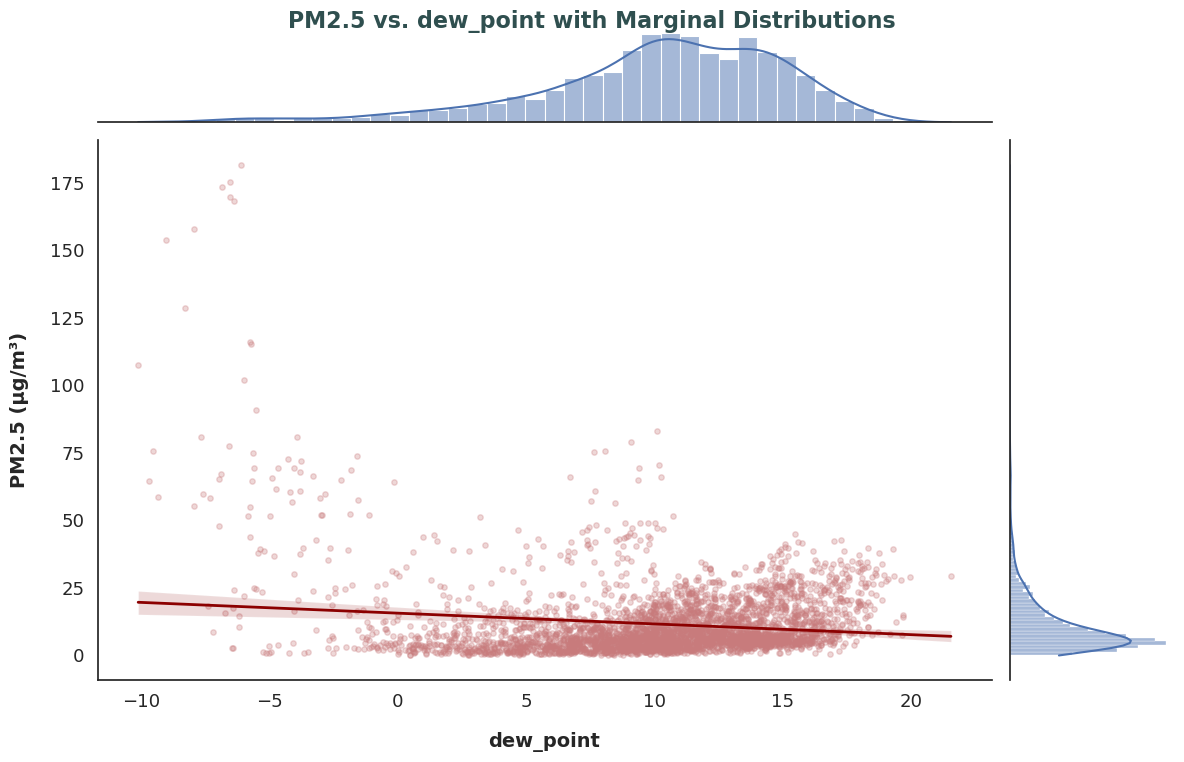

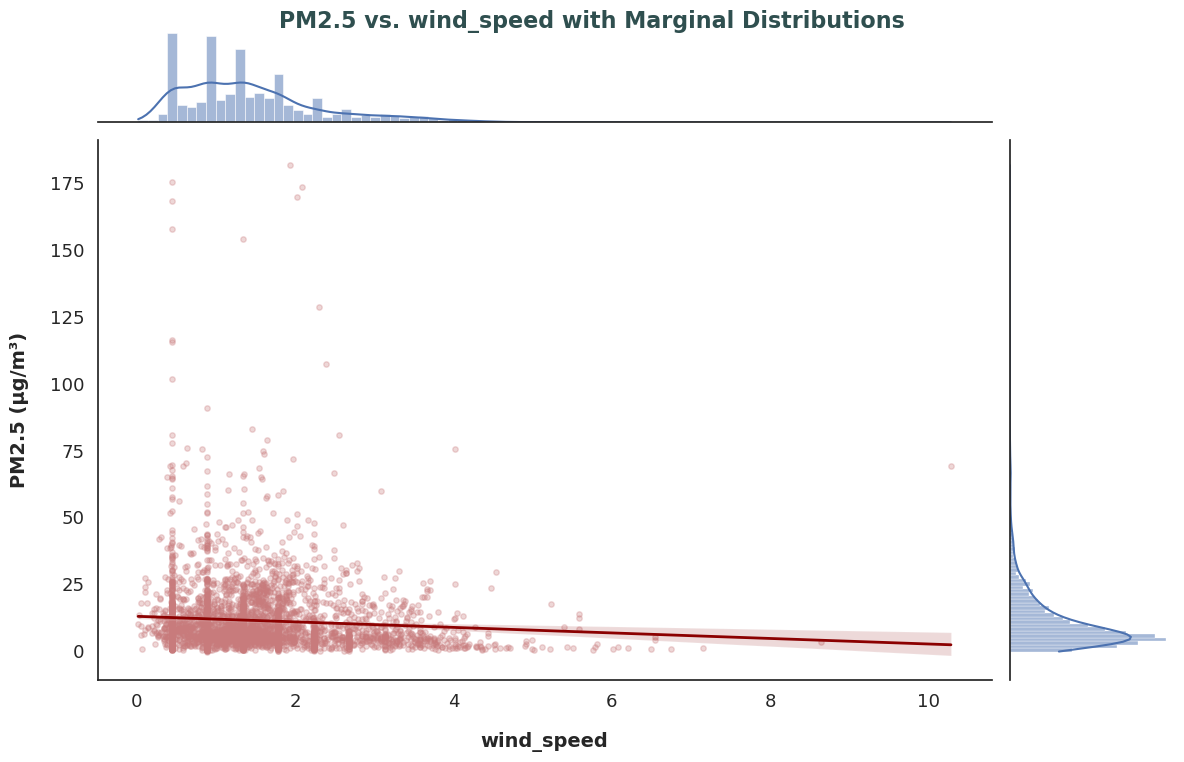

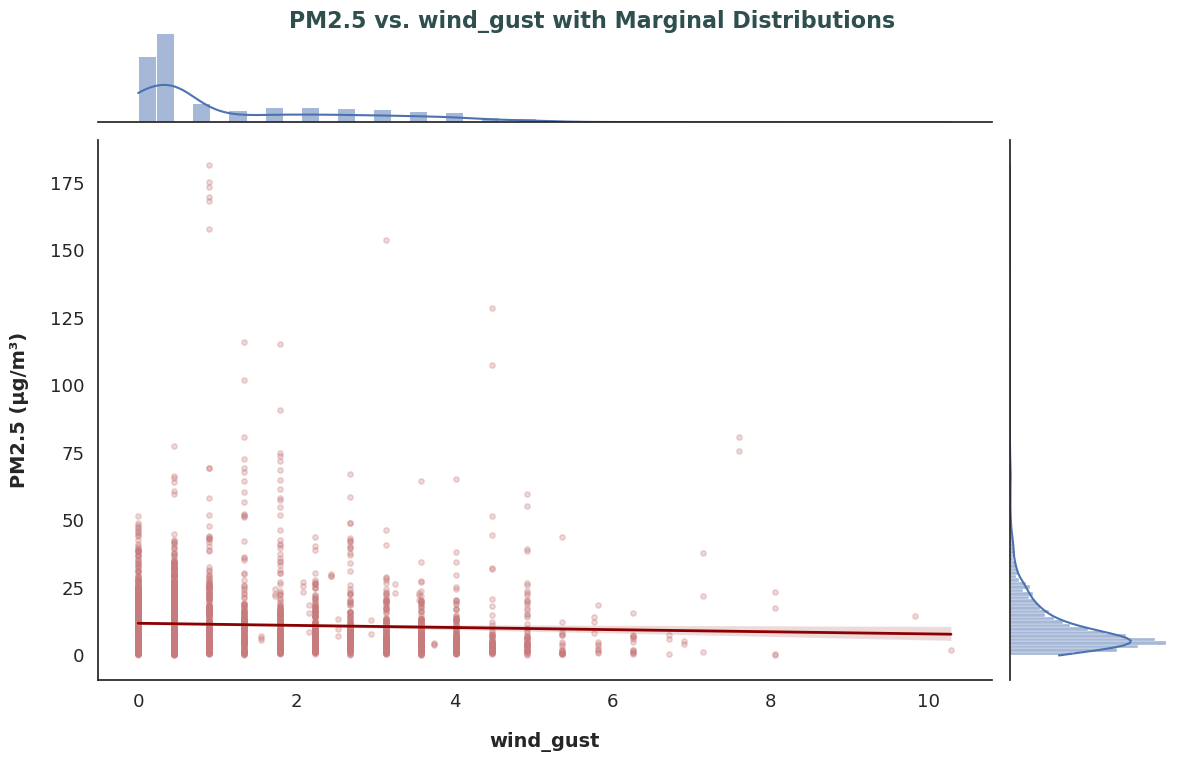

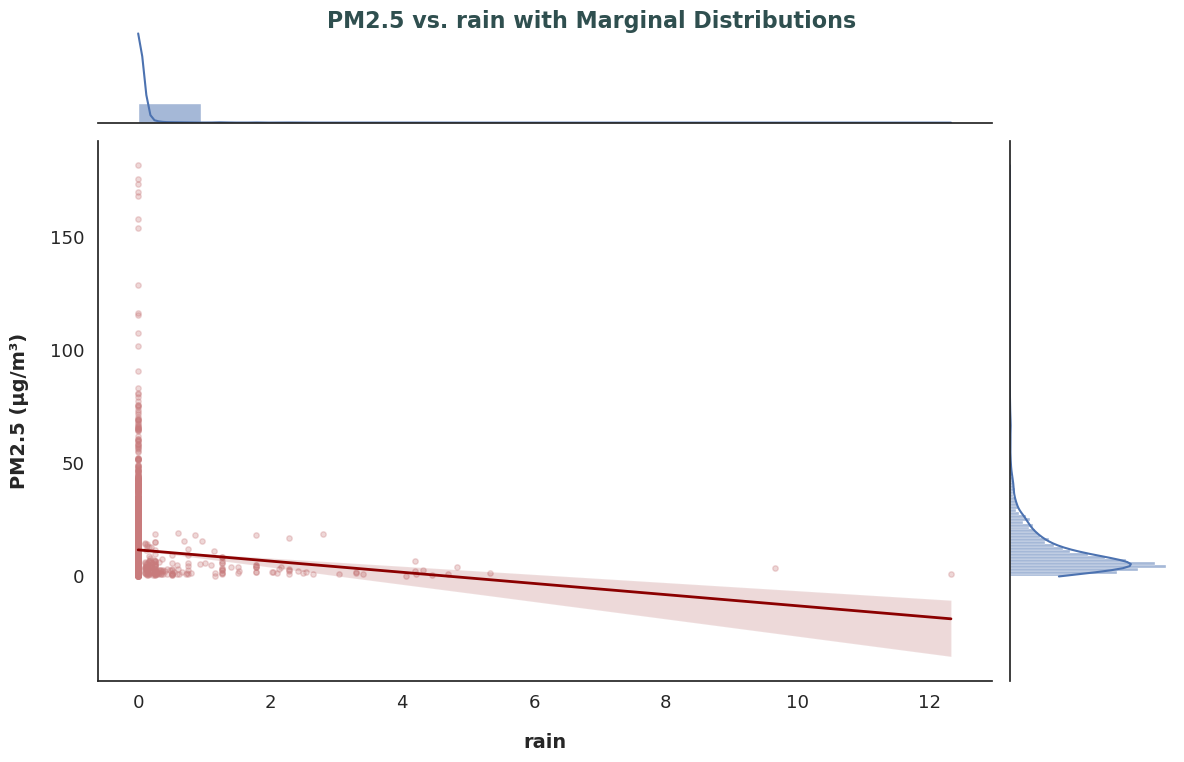

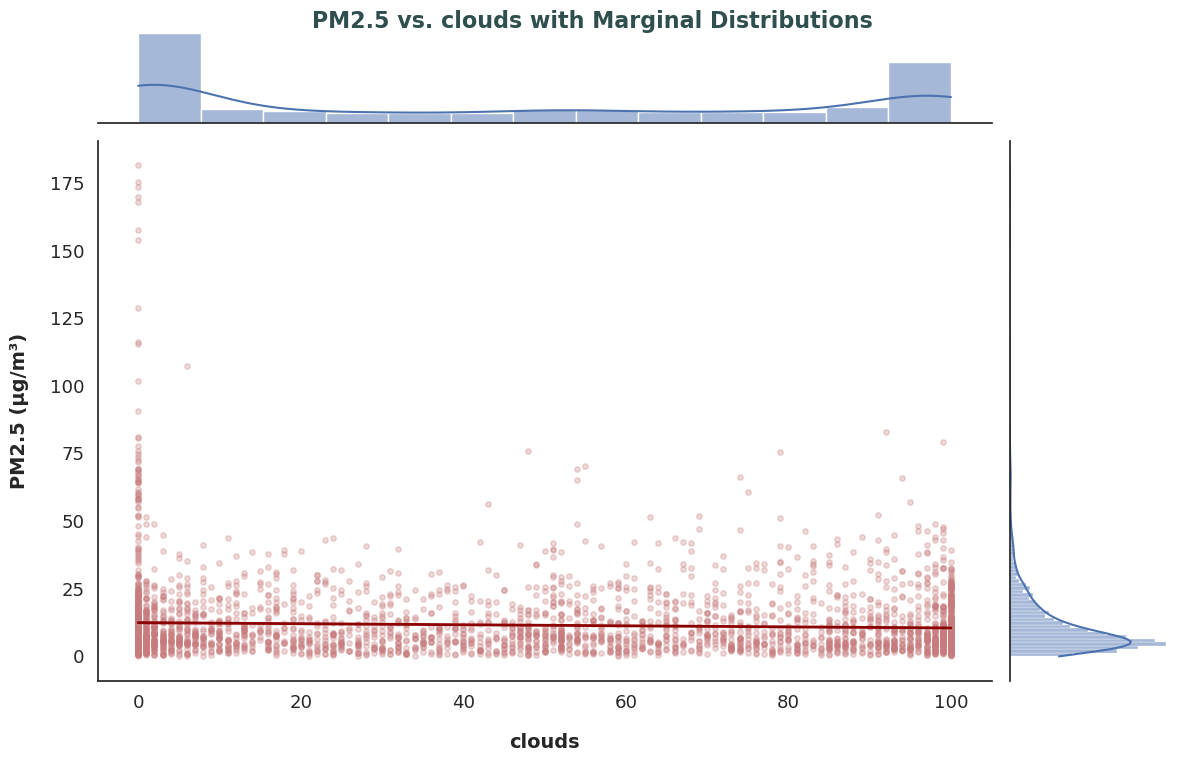

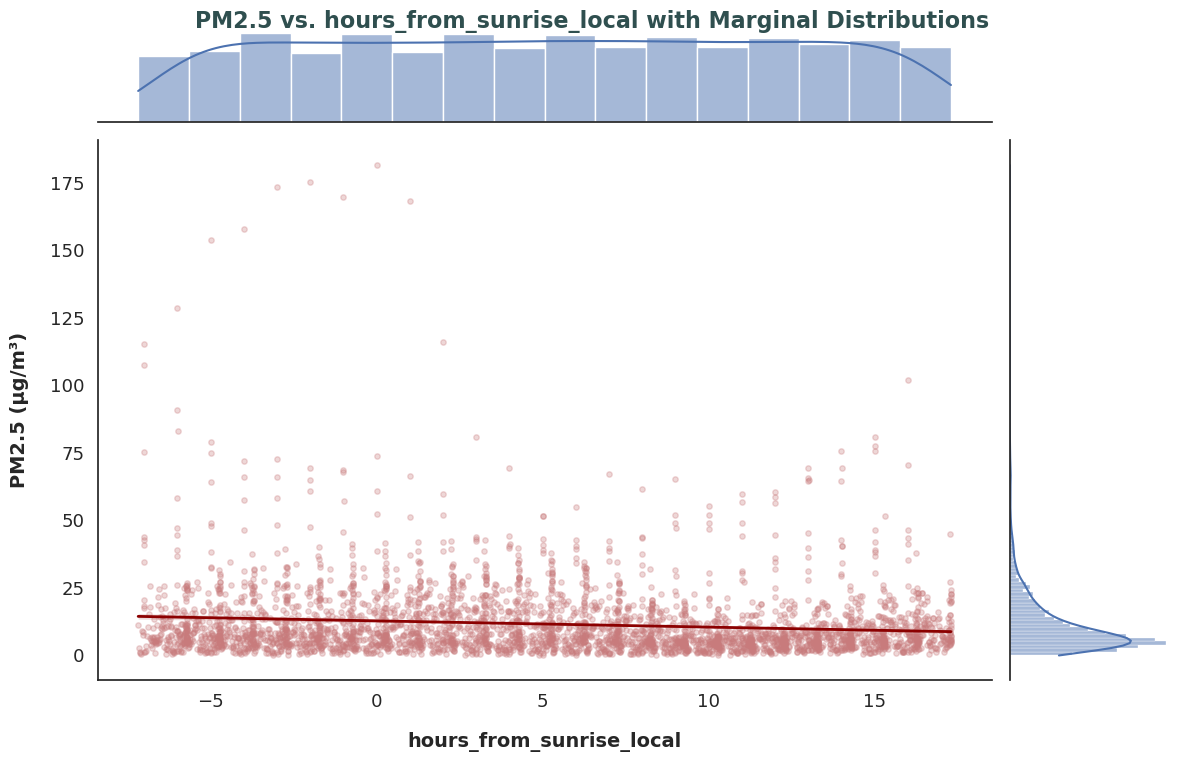

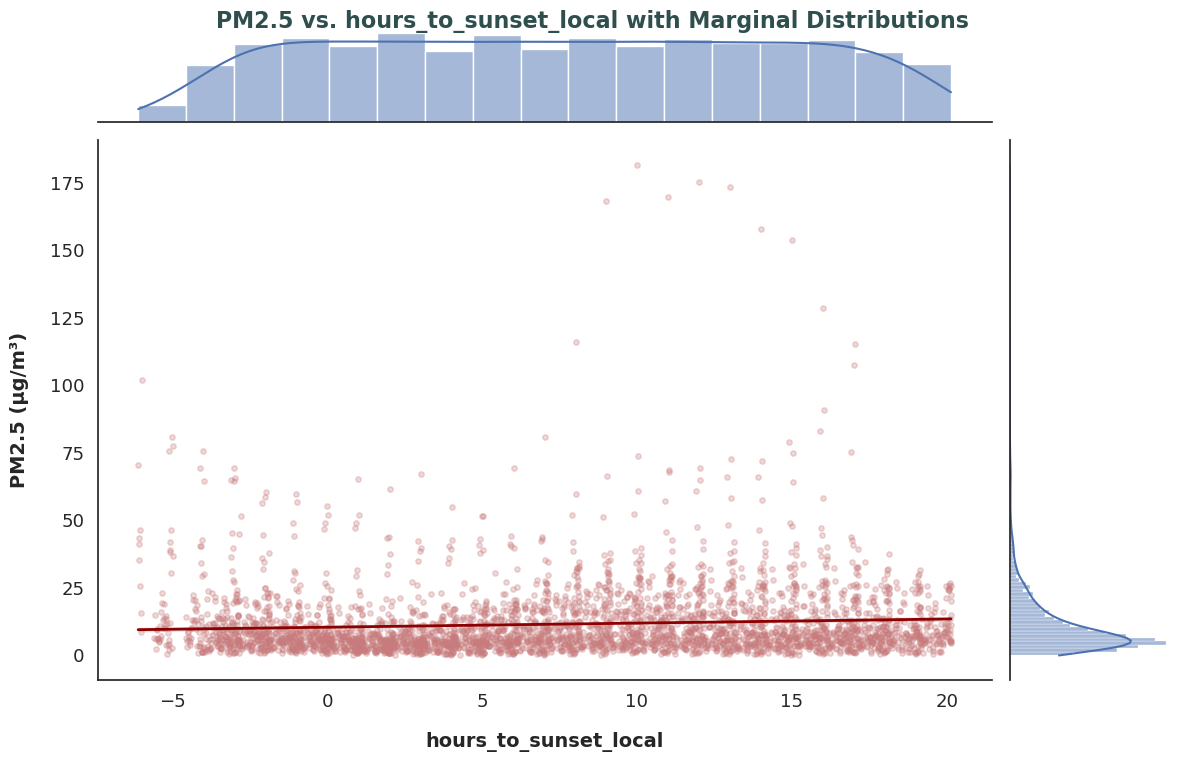

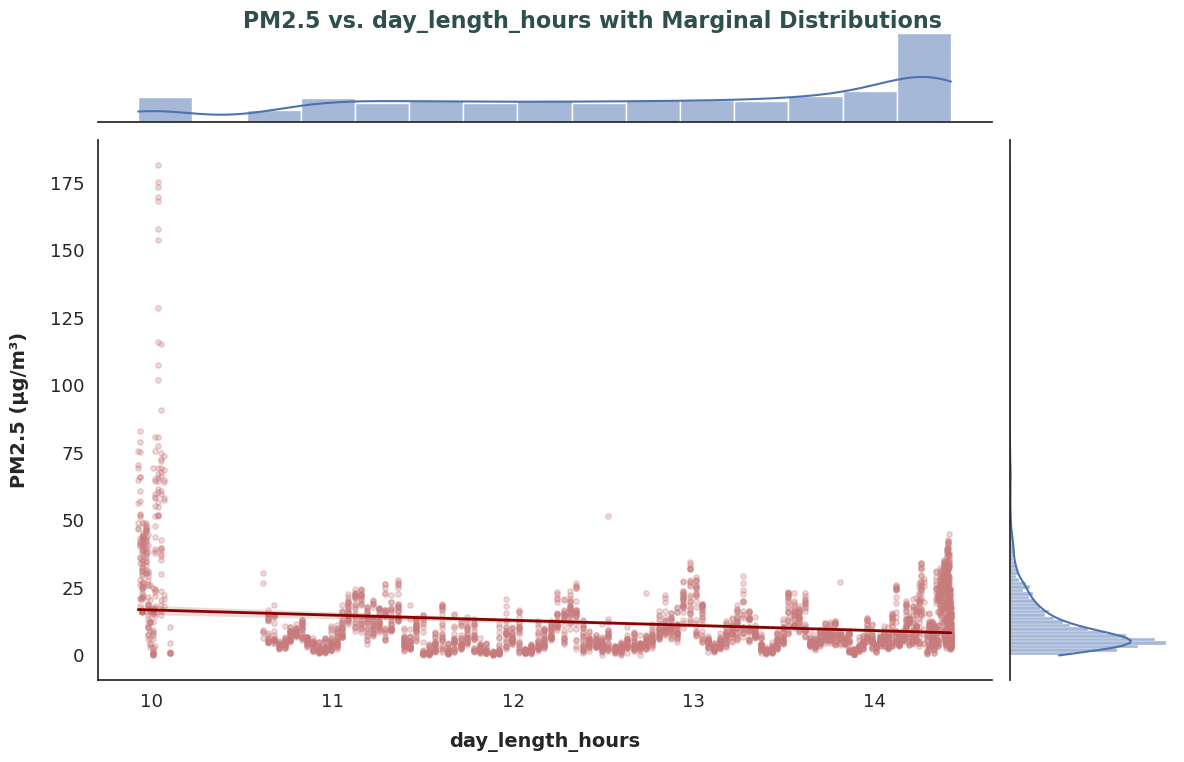

In [43]:
for col in weather_numeric_cols:
    g = sns.jointplot(x=col, y='pm25', data=combined_weather_df, kind='reg',
                      height=7, # Increased height for a larger plot section within the jointplot
                      scatter_kws={'alpha': 0.3, 'color': custom_palette[3], 's':15},
                      line_kws={'color': 'darkred', 'linewidth': 2})
    g.fig.set_size_inches(12, 8)
    g.fig.suptitle(f'PM2.5 vs. {col} with Marginal Distributions', y=0.95, fontsize=16, fontweight='bold', color='darkslategray')
    g.ax_joint.set_xlabel(col, fontsize=14, weight='bold', labelpad=15)
    g.ax_joint.set_ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15)
    g.ax_joint.tick_params(axis='x', labelsize=13)
    g.ax_joint.tick_params(axis='y', labelsize=13)
    plt.tight_layout()
    plt.show()

__PM2.5 and Weather Relationships__

The joint plots show scatter plots of PM2.5 against various continuous weather variables, along with marginal distributions and a regression line.

__Temp/Feels like ("PM2.5 vs. temp" and "PM2.5 vs. feels_like")__
Both plots indicate a very weak, almost flat linear relationship between PM2.5 and temperature/feels like temperature. The regression lines are nearly horizontal. This suggests that within the observed temperature range, there isn't a strong direct linear correlation; PM2.5 concentrations are widely scattered across all temperature values.

__Humidity ("PM2.5 vs. humidity")__
There appears to be a slight negative linear relationship. As humidity increases, the PM2.5 concentration shows a tendency to slightly decrease, as indicated by the subtle downward slope of the regression line. This could suggest that higher humidity levels (perhaps leading to some form of wet deposition or more stable air conducive to less emissions) might be associated with slightly lower PM2.5.

__Pressure ("PM2.5 vs. pressure")__
The plot shows a weak positive linear correlation. As atmospheric pressure increases, there's a minor upward trend in PM2.5 concentration, as shown by the slightly upward-sloping regression line. This might reflect conditions where high-pressure systems lead to more stable air, trapping pollutants.

__Wind Speed and Gusts ("PM2.5 vs. wind_speed" and "PM2.5 vs. wind_gust")__
Both wind speed and wind gusts exhibit a clear and moderate negative linear relationship with PM2.5. As wind speed or gust strength increases, PM2.5 concentrations generally decrease, indicated by the downward-sloping regression lines. This is expected, as stronger winds help disperse airborne pollutants, leading to lower concentrations.

__Dew Point ("PM2.5 vs. dew_point")__
The plot suggests a weak negative linear correlation. The regression line shows a slight downward slope, indicating that as the dew point increases, PM2.5 concentrations tend to slightly decrease. This contrasts with a positive correlation and implies that higher moisture content in the air (as indicated by dew point) might coincide with conditions that reduce PM2.5, possibly due to associated meteorological factors.

__Rainfall ("PM2.5 vs. rain")__
There is a noticeable negative linear relationship. Higher amounts of rain are strongly associated with lower PM2.5 concentrations, evidenced by the downward-sloping regression line. This reflects the well-known "washout" effect of precipitation, where rain cleanses particles from the atmosphere.

__Cloud Cover ("PM2.5 vs. clouds")__
The plot indicates no strong linear relationship between cloud cover percentage and PM2.5. The regression line is largely flat, and PM2.5 values are widely dispersed across all cloud cover levels. This suggests that cloud cover alone, in a linear fashion, is not a primary driver of PM2.5 concentrations in this dataset.

__Sunlight-Based Features (Pages 10-11: "PM2.5 vs. hours_from_sunrise_local", "PM2.5 vs. hours_to_sunset_local", "PM2.5 vs. day_length_hours")__

_For "hours_from_sunrise_local" and "hours_to_sunset_local", the plots show very weak linear relationships. While these features are derived from the daily cycle, the simple linear regression lines are relatively flat. This implies that the impact of the solar cycle on PM2.5 is likely highly non-linear and interconnected with other factors like atmospheric stability and photochemical reactions, rather than a simple direct linear trend.

_For "day_length_hours", there's also a very weak, slightly negative linear relationship. As day length increases, there's a subtle tendency for PM2.5 to be marginally lower, but the correlation is not strong.

__Correlation Heatmap (Overall Relationships)__

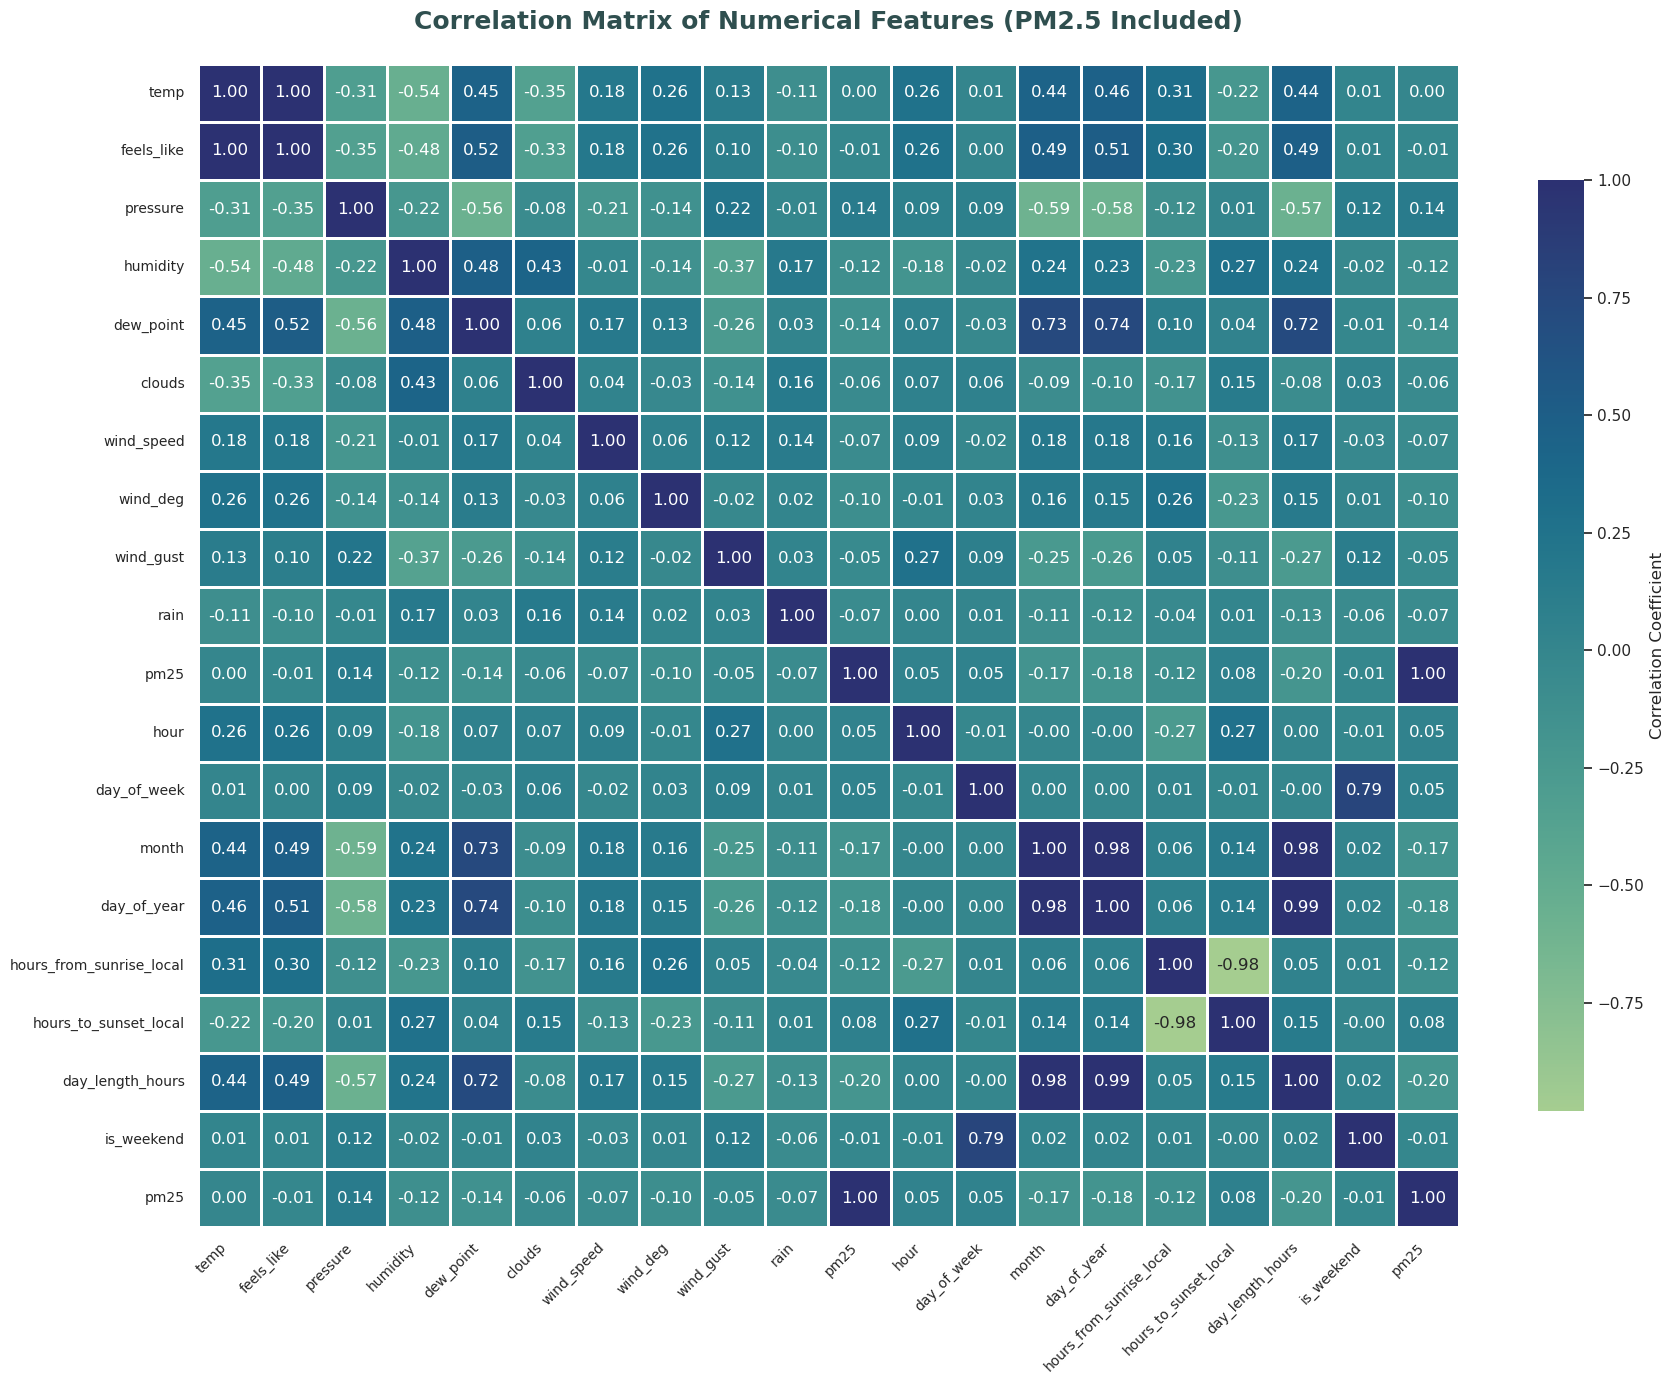

In [44]:
plt.figure(figsize=(18, 14))
correlation_matrix = combined_weather_df[numerical_cols + ['pm25']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f", linewidths=.8, linecolor='white',
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features (PM2.5 Included)', fontsize=18, fontweight='bold', color='darkslategray', pad=25) # Added pad
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In summary:

Strongest Linear Influences: day_of_year, day_length_hours, and month show the most significant linear correlations with PM2.5, highlighting the strong seasonal effect in your data (PM2.5 tends to be lower in later months with longer daylight).

Moderate/Weak Influences: pressure, humidity, dew_point, and wind-related features (wind_speed, wind_deg, wind_gust, rain) show consistent, albeit weak, linear relationships, generally aligning with expected meteorological impacts on pollutant dispersion.

Negligible Linear Influences: temp, feels_like, clouds, hour, day_of_week, and is_weekend show very little linear correlation, even if they might have important non-linear or indirect relationships as observed in your EDA (e.g., hourly patterns, weekday vs. weekend averages).

This correlation matrix provides valuable insights for feature selection and understanding linear dependencies, but it's important to remember that Pearson correlation only captures linear relationships. As your successful ML models demonstrated, many variables, especially temporal ones, might have strong non-linear impacts on PM2.5 that a simple correlation matrix won't fully reveal.

# Modeling and Evaluation

## Data Preparation for Time Series Modeling

In [45]:
combined_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3702 entries, 2025-01-01 00:00:00+00:00 to 2025-06-30 23:00:00+00:00
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype                              
---  ------                    --------------  -----                              
 0   temp                      3702 non-null   float64                            
 1   feels_like                3702 non-null   float64                            
 2   pressure                  3702 non-null   int64                              
 3   humidity                  3702 non-null   int64                              
 4   dew_point                 3702 non-null   float64                            
 5   clouds                    3702 non-null   int64                              
 6   wind_speed                3702 non-null   float64                            
 7   wind_deg                  3702 non-null   int64                              
 8   wind_gust 

In [46]:
# modeling_df = 

In [47]:
features_to_exclude = ['pm25'] 
# Select all numerical columns as potential features, then exclude the target and identifiers
X = combined_weather_df.select_dtypes(include=np.number).drop(columns=features_to_exclude, errors='ignore')
y = combined_weather_df['pm25']

In [48]:
# Perform time-based train-test split 80% for training, 20% for testing.
train_size = int(len(combined_weather_df) * 0.8) 

In [49]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [50]:
print(f"Total data points: {len(combined_weather_df)}")
print(f"Training set size: {len(X_train)} (approx {len(X_train)/len(combined_weather_df):.1%} of total)")
print(f"Testing set size: {len(X_test)} (approx {len(X_test)/len(combined_weather_df):.1%} of total)")

Total data points: 3702
Training set size: 2961 (approx 80.0% of total)
Testing set size: 741 (approx 20.0% of total)


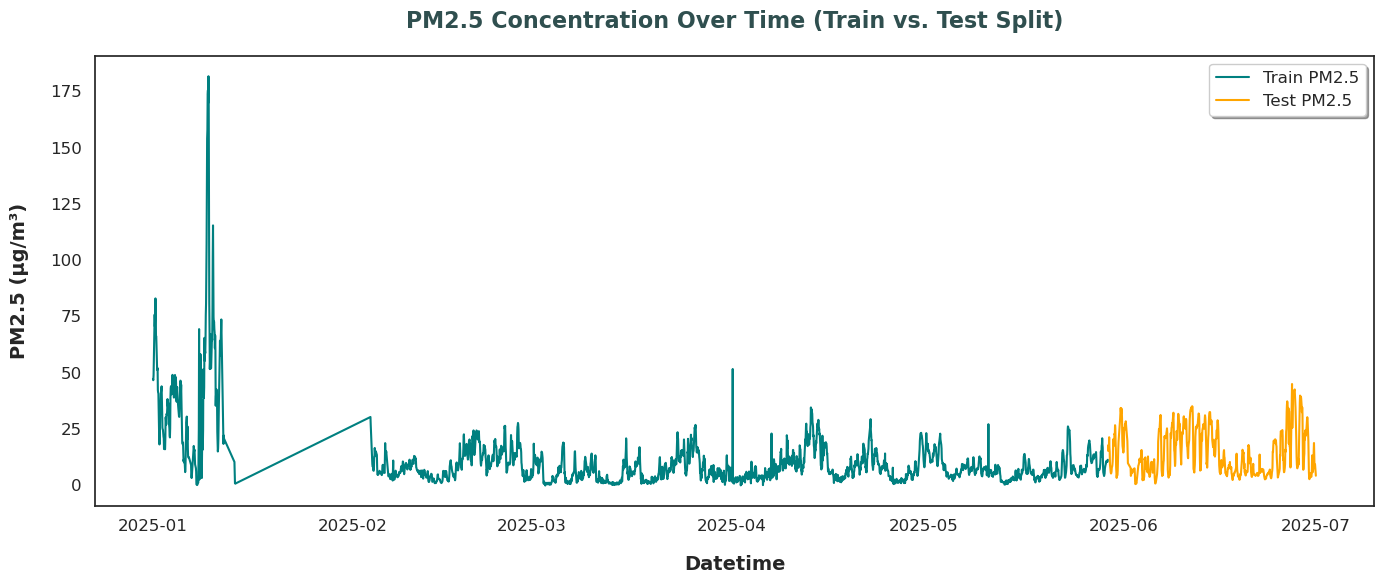

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train PM2.5', color='teal', linewidth=1.5)
plt.plot(y_test.index, y_test, label='Test PM2.5', color='orange', linewidth=1.5)
plt.title('PM2.5 Concentration Over Time (Train vs. Test Split)', fontsize=16, fontweight='bold', color='darkslategray', pad=20)
plt.ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15)
plt.xlabel('Datetime', fontsize=14, weight='bold', labelpad=15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

In [52]:
# 1. Check for Stationarity using ADF Test on y_train
print("\n--- Performing ADF Test on y_train (PM2.5) ---")
adf_result = adfuller(y_train)
print(f"ADF Statistic: {adf_result[0]:.2f}")
print(f"p-value: {adf_result[1]:.3f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.2f}")

if adf_result[1] <= 0.05:
    print("Conclusion: The series is likely stationary (p-value <= 0.05). No differencing (d=0) might be needed for the non-seasonal part.")
    d_param = 0
else:
    print("Conclusion: The series is likely non-stationary (p-value > 0.05). Differencing (d=1) might be needed for the non-seasonal part.")
    d_param = 1


--- Performing ADF Test on y_train (PM2.5) ---
ADF Statistic: -5.93
p-value: 0.000
Critical Values:
  1%: -3.43
  5%: -2.86
  10%: -2.57
Conclusion: The series is likely stationary (p-value <= 0.05). No differencing (d=0) might be needed for the non-seasonal part.


In [53]:
# Utility Function to calculate the model performance metrics
# It takes actuala nd predicted values as inpute and returns MAE, RMSE, SMAPE of the model
def calculate_metrics(y_true: pd.Series, y_pred: pd.Series, model_name: str) -> dict:

    # Ensure y_pred is aligned with y_true's index
    y_pred_aligned = y_pred.reindex(y_true.index)

    mae = mean_absolute_error(y_true, y_pred_aligned)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_aligned))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

    print(f"\n--- {model_name} Model Evaluation ---")
    print(f"{model_name} Mean Absolute Error (MAE): {mae:.4f}")
    print(f"{model_name} Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"{model_name} Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}")

    return {"MAE": mae, "RMSE": rmse, "SMAPE":smape}

In [54]:
# Reusable function to plot the actual vs forecatsed time series
# It takes actual and predicted values and plot a line pot to compare the values predicted by each model
def plot_forecast(y_true: pd.Series, y_pred: pd.Series, model_name: str, color_pred: str = 'orange', linestyle_pred: str = '--'):

    plt.figure(figsize=(18, 7))
    plt.plot(y_true.index, y_true, label='Actual PM2.5', color='teal', linewidth=3.5, alpha=0.7)
    plt.plot(y_pred.index, y_pred, label=f'{model_name} Forecast', color=color_pred, linewidth=2.5,  linestyle=linestyle_pred)
    plt.title(f'{model_name} Forecast vs Actual PM2.5 Concentration', fontsize=16, fontweight='bold', color='darkslategray', pad=25)
    plt.xlabel('Datetime', fontsize=14, weight='bold', labelpad=15)
    plt.ylabel('PM2.5 (µg/m³)', fontsize=14, weight='bold', labelpad=15)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.legend(fontsize=12, frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()

## Model Selection and Configuration

### Baseline Model: SARIMA (univariate)

In [55]:
# Define SARIMA parameters based on common practice or initial exploration
# (p,d,q) - non-seasonal part
# (P,D,Q,S) - seasonal part (S=24 for hourly data, 24*7=168 for weekly if data is daily)
# Based on common hourly patterns, a seasonal period of 24 is typical.
# Use d_param from ADF test for non-seasonal differencing.
# For seasonal differencing (D), 1 is a common starting point if strong seasonality is present.
sarima_order = (1, d_param, 1)
sarima_seasonal_order = (1, 1, 1, 24) # P=1, D=1, Q=1, S=24 hours

In [56]:
sarima_model = SARIMAX(y_train,
                       order=sarima_order,
                       seasonal_order=sarima_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               pm25   No. Observations:                 2961
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -8073.233
Date:                            Sun, 20 Jul 2025   AIC                          16156.465
Time:                                    20:15:50   BIC                          16186.346
Sample:                                         0   HQIC                         16167.230
                                           - 2961                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9486      0.002    555.319      0.000       0.945       0.952
ma.L1          0.0587      0.004   

In [57]:
# 3. Make predictions on the test set using numerical indices
# Forecast starts immediately after the training data ends
sarima_forecast_start_idx = len(y_train)
# Forecast ends at the last point of the test data
sarima_forecast_end_idx = len(y_train) + len(y_test) - 1

In [58]:
sarima_pred = sarima_results.predict(start=sarima_forecast_start_idx, end=sarima_forecast_end_idx, typ='levels')

# Reindex the prediction to align with the y_test index for accurate comparison and plotting
sarima_pred.index = y_test.index

In [59]:
# Use the reusable functions for metrics and plotting
sarima_metrics = calculate_metrics(y_test, sarima_pred, "SARIMA")


--- SARIMA Model Evaluation ---
SARIMA Mean Absolute Error (MAE): 9.0462
SARIMA Root Mean Squared Error (RMSE): 12.2235
SARIMA Symmetric Mean Absolute Percentage Error (SMAPE): 66.1365


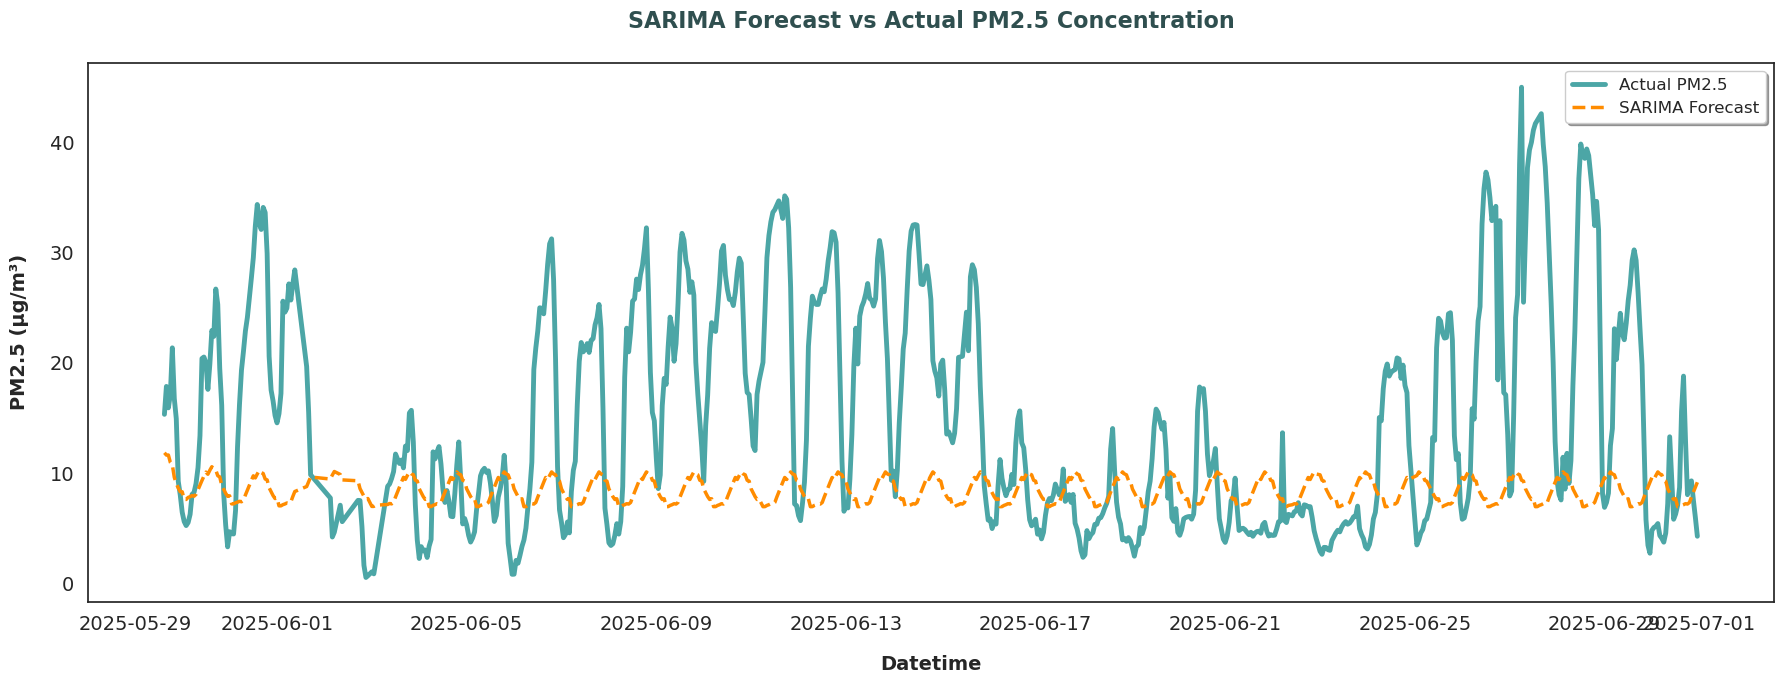

In [60]:
plot_forecast(y_test, sarima_pred, "SARIMA", color_pred='darkorange', linestyle_pred='--')

SARIMA (Univariate Baseline Model):

Process: A Seasonal Autoregressive Integrated Moving Average (SARIMA) model was fitted to the y_train data. Based on the ADF test, the non-seasonal differencing parameter d was set to 0. Standard seasonal parameters (P,D,Q,S) were chosen as (1,1,1,24), assuming a strong hourly seasonality (S=24).

Results: The SARIMA model, fitted with order=(1,0,1) and seasonal_order=(1,1,1,24), yielded the following performance metrics on the test set:

MAE: 9.0462 µg/m³

RMSE: 12.2235 µg/m³

SMAPE: 66.1365%

The forecast plot showed that SARIMA captured the general trends but struggled to accurately predict sharp peaks and rapid fluctuations in the PM2.5 series, indicating limitations in capturing complex, non-linear dynamics.

### Multivariate Time Series: SARIMAX (with exog)

In [61]:
# Define the specific exogenous columns from your ver1 notebook
exog_cols = [
    "temp", "feels_like", "humidity", "dew_point", "pressure",
    "clouds", "wind_speed", "wind_deg", "wind_gust", "rain"
]

In [62]:
# Combine y and X for the relevant columns to ensure rows are dropped consistently
df_train_subset = pd.concat([y_train, X_train[exog_cols]], axis=1)
df_test_subset = pd.concat([y_test, X_test[exog_cols]], axis=1)

In [63]:
# Drop rows with NaN values from the combined (y + X) dataframes
df_train_subset.dropna(inplace=True)
df_test_subset.dropna(inplace=True)

In [64]:
# Separate back into the (potentially shortened) y and X sets
y_train1 = df_train_subset[y_train.name]
X_train_exog = df_train_subset.drop(columns=[y_train.name])

y_test1 = df_test_subset[y_test.name]
X_test_exog = df_test_subset.drop(columns=[y_test.name])

In [65]:
# Ensure all columns are numeric
X_train_exog = X_train_exog.select_dtypes(include=np.number)
X_test_exog = X_test_exog.select_dtypes(include=np.number)

# Make sure the order of columns in X_test_exog matches X_train_exogd
X_test_exog = X_test_exog[X_train_exog.columns]

In [66]:
# Define SARIMAX parameters
sarimax_order = (1, d_param, 1)
sarimax_seasonal_order = (1, 1, 1, 24) # P=1, D=1, Q=1, S=24 hours

In [67]:
sarimax_model = SARIMAX(y_train1,
                        exog=X_train_exog, # Pass the prepared exogenous variables here
                        order=sarimax_order,
                        seasonal_order=sarimax_seasonal_order,
                        enforce_stationarity=False, # Allow statsmodels to handle differencing internally
                        enforce_invertibility=False)
sarimax_results = sarimax_model.fit(disp=False) # disp=False suppresses convergence output
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               pm25   No. Observations:                 2946
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -8010.272
Date:                            Sun, 20 Jul 2025   AIC                          16050.543
Time:                                    20:17:23   BIC                          16140.109
Sample:                                         0   HQIC                         16082.818
                                           - 2946                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -2.7841      0.303     -9.181      0.000      -3.378      -2.190
feels_like     2.0350      0.281   

In [68]:
# Forecast starts immediately after the training data ends (numerical index)
sarimax_forecast_start_idx = len(y_train1)
# Forecast ends at the last point of the test data (numerical index relative to original series length)
sarimax_forecast_end_idx = len(y_train1) + len(y_test) - 1

sarimax_pred = sarimax_results.predict(start=sarimax_forecast_start_idx,
                                       end=sarimax_forecast_end_idx,
                                       exog=X_test_exog, # Crucial: Pass exogenous variables for prediction
                                       typ='levels') # 'levels' returns the actual predicted values

# Reindex the prediction to align with the y_test index for accurate comparison and plotting
sarimax_pred.index = y_test.index

In [69]:
# Calculate metrics using the reusable function
sarimax_metrics = calculate_metrics(y_test, sarimax_pred, "SARIMAX")


--- SARIMAX Model Evaluation ---
SARIMAX Mean Absolute Error (MAE): 9.3266
SARIMAX Root Mean Squared Error (RMSE): 12.6831
SARIMAX Symmetric Mean Absolute Percentage Error (SMAPE): 69.5930


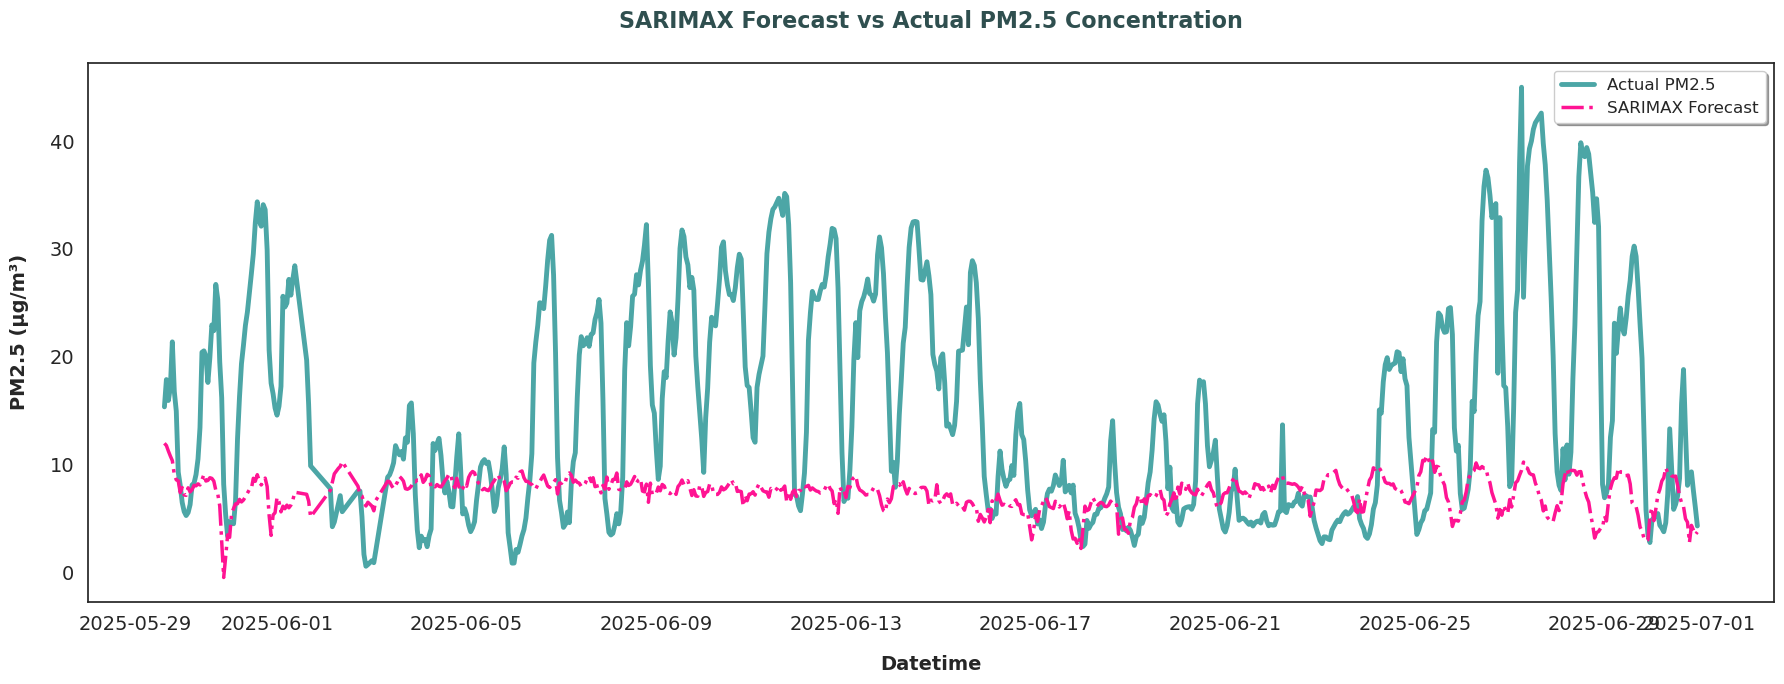

In [70]:
# Plot the forecast using the reusable function
plot_forecast(y_test, sarimax_pred, "SARIMAX", color_pred='deeppink', linestyle_pred='-.')

Process: Building upon SARIMA, a SARIMAX model was implemented to incorporate exogenous (external) weather variables. The chosen exogenous features included: "temp", "feels_like", "humidity", "dew_point", "pressure", "clouds", "wind_speed", "wind_deg", "wind_gust", and "rain". Training and test sets for the exogenous variables were carefully aligned with the PM2.5 target variable, handling any missing values. The same SARIMA orders were used.

Results: The SARIMAX model, incorporating weather features, produced the following metrics:

MAE: 9.3266 µg/m³

RMSE: 12.6831 µg/m³

SMAPE: 69.5930%

Surprisingly, SARIMAX's performance was slightly worse than the univariate SARIMA model across all metrics. This suggests that the linear relationships captured by SARIMAX with these specific exogenous variables were either not strong enough to improve the model or that the model's assumptions did not fully align with the complex interactions between PM2.5 and weather. The forecast plot exhibited similar limitations to SARIMA in capturing extreme events.

## Machine Learning Models: Enhanced Feature Engineering

In [71]:
ml_weather_df = combined_weather_df.copy() # Start with your full merged dataframe
ml_weather_df.dropna(inplace=True)

In [72]:
target_col = "pm25"

In [73]:
#  Create Lag Features and Rolling Averages for PM2.5 
for lag in [1, 3, 6, 12]:
    if target_col in ml_weather_df.columns:
        ml_weather_df[f"{target_col}_lag_{lag}"] = ml_weather_df[target_col].shift(lag)
    else:
        print(f"Warning: Target column '{target_col}' not found in df_ml. Cannot create lag features.")
        break
print(f"Created lag features for '{target_col}'.")

Created lag features for 'pm25'.


In [74]:
if target_col in ml_weather_df.columns:
    ml_weather_df[f"{target_col}_roll_6"] = ml_weather_df[target_col].rolling(window=6).mean()
    ml_weather_df[f"{target_col}_roll_12"] = ml_weather_df[target_col].rolling(window=12).mean()
    print(f"Created rolling mean features for '{target_col}'.")

Created rolling mean features for 'pm25'.


In [75]:
# Drop rows with NaN values introduced by lagging/rolling
ml_weather_df.dropna(inplace=True)

In [76]:
# Feature Selection for ML Models 
features = [
    "temp", "feels_like", "pressure", "humidity", "dew_point", "clouds",
    "wind_speed", "wind_deg", "wind_gust", "rain", # All numerical weather features
    f"{target_col}_lag_1", f"{target_col}_lag_3", f"{target_col}_lag_6", f"{target_col}_lag_12", # Lag features
    f"{target_col}_roll_6", f"{target_col}_roll_12", # Rolling features
    "hour", "day_of_week", "month", "day_of_year", "is_weekend", # Time-based features
    "day_length_hours", "is_daylight", "hours_from_sunrise_local", "hours_to_sunset_local" 
]

In [77]:
# Filter features to ensure all selected features actually exist in df_ml columns
features = [f for f in features if f in ml_weather_df.columns]

In [78]:
X = ml_weather_df[features]
y = ml_weather_df[target_col]

In [79]:
# Calculate the split index for an 80% train / 20% test split
split_index = int(len(ml_weather_df) * 0.80)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [80]:

print(f"ML Train set shape (80%): X={X_train.shape}, y={y_train.shape}")
print(f"ML Test set shape (20%): X={X_test.shape}, y={y_test.shape}")

ML Train set shape (80%): X=(2940, 25), y=(2940,)
ML Test set shape (20%): X=(735, 25), y=(735,)


__Enhanced Feature Engineering for ML:__

Process: To better leverage the dataset for ML models, additional time-series specific features were engineered:

Lag Features: Past PM2.5 values at intervals of 1, 3, 6, and 12 hours (pm25_lag_1 to pm25_lag_12) were created to explicitly capture autoregressive dependencies.

Rolling Mean Features: Moving averages of PM2.5 over 6-hour (pm25_roll_6) and 12-hour (pm25_roll_12) windows were calculated to provide smoothed trend information.

These were combined with all available numerical weather features (temperature, humidity, wind, etc.) and various temporal features (hour, day of week, month, day of year, day length, daylight indicators) to form a comprehensive feature set for supervised learning.

Results: The enhanced feature set resulted in an ML training set of 2940 data points with 25 features, and a testing set of 735 data points with the same features, ensuring robust input for the models.

__Random Forest Regressor__

In [81]:
rf_model = RandomForestRegressor(n_estimators=100,
                                 random_state=42, 
                                 n_jobs=-1)

In [82]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [83]:
rf_preds = rf_model.predict(X_test)
rf_preds = pd.Series(rf_preds, index=y_test.index, name='RandomForest_Prediction')

In [84]:
# Evaluate the model using the existing calculate_metrics function
rf_metrics = calculate_metrics(y_test, rf_preds, "Random Forest")


--- Random Forest Model Evaluation ---
Random Forest Mean Absolute Error (MAE): 2.1192
Random Forest Root Mean Squared Error (RMSE): 3.0256
Random Forest Symmetric Mean Absolute Percentage Error (SMAPE): 17.0947


In [85]:
# Store predictions for the comparative plot
ml_predictions = {}
ml_predictions['Random Forest'] = rf_preds

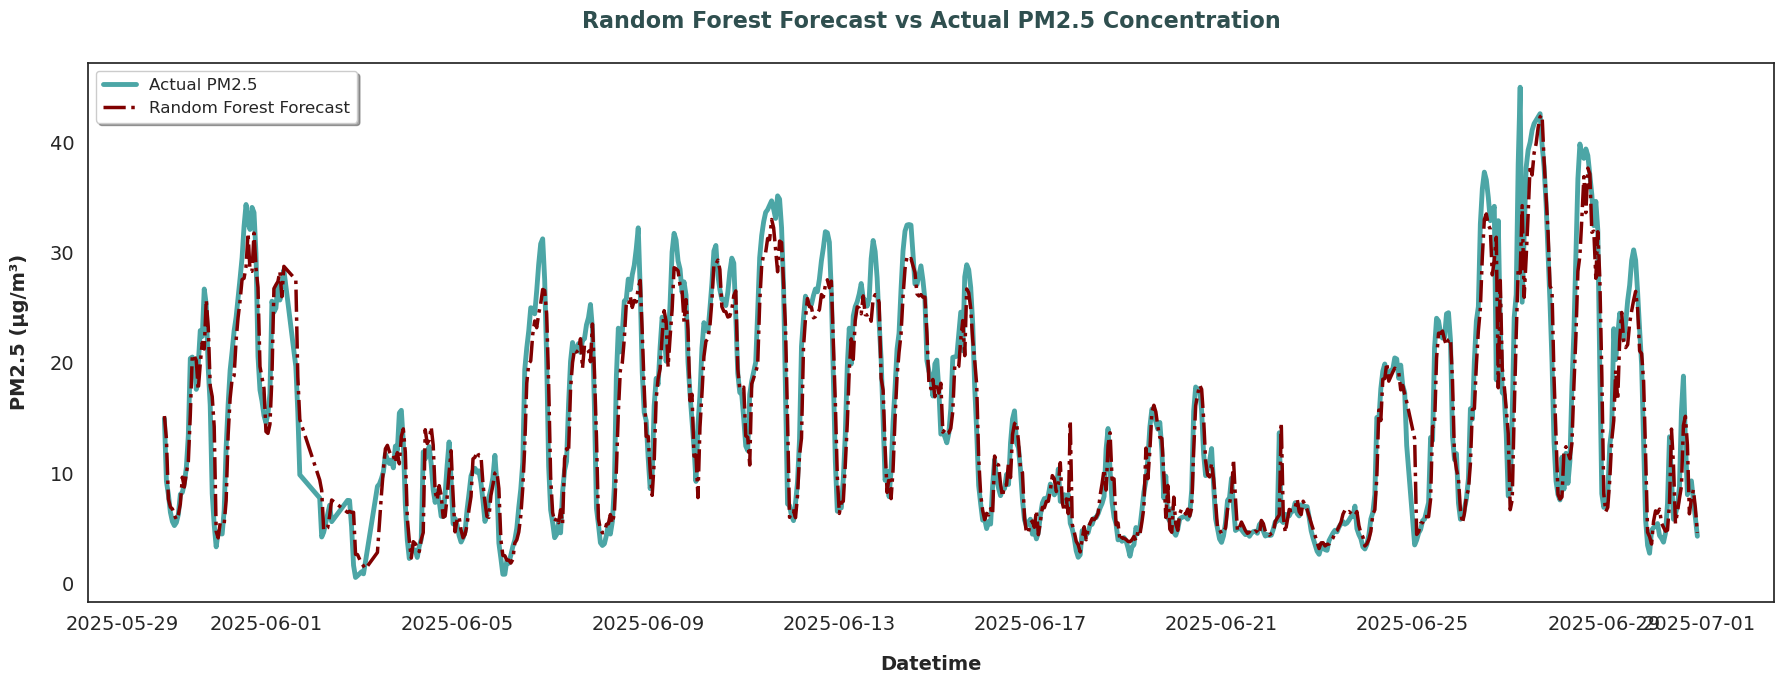

In [86]:
# Plot the forecast using the reusable function
plot_forecast(y_test, rf_preds, "Random Forest", color_pred='maroon', linestyle_pred='-.')

Process: A Random Forest Regressor was trained on the enhanced feature set. This ensemble model constructs multiple decision trees during training and outputs the average prediction of individual trees, making it robust to overfitting and capable of handling non-linear relationships. Hyperparameters were set to n_estimators=100 and random_state=42.

Results: The Random Forest model demonstrated significantly superior performance:

MAE: 2.1192 µg/m³

RMSE: 3.0256 µg/m³

SMAPE: 17.0947%

The forecast plot showed the Random Forest model providing predictions that closely tracked the actual PM2.5 concentrations, even capturing many of the sharper peaks and troughs much more effectively than the SARIMA/SARIMAX models.

__XGBoost Regressor__

In [87]:
# Define XGBoost Regressor parameters
xgb_model = XGBRegressor(n_estimators=100,
                         learning_rate=0.1,
                         random_state=42,
                         n_jobs=-1)

In [88]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [89]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = pd.Series(xgb_preds, index=y_test.index, name='XGBoost_Prediction')

In [90]:
# Evaluate the model using the existing calculate_metrics function
xgb_metrics = calculate_metrics(y_test, xgb_preds, "XGBoost")


--- XGBoost Model Evaluation ---
XGBoost Mean Absolute Error (MAE): 2.4692
XGBoost Root Mean Squared Error (RMSE): 3.7526
XGBoost Symmetric Mean Absolute Percentage Error (SMAPE): 18.1604


In [91]:
# Add XGBoost predictions to the dictionary for the comparative plot
ml_predictions['XGBoost'] = xgb_preds

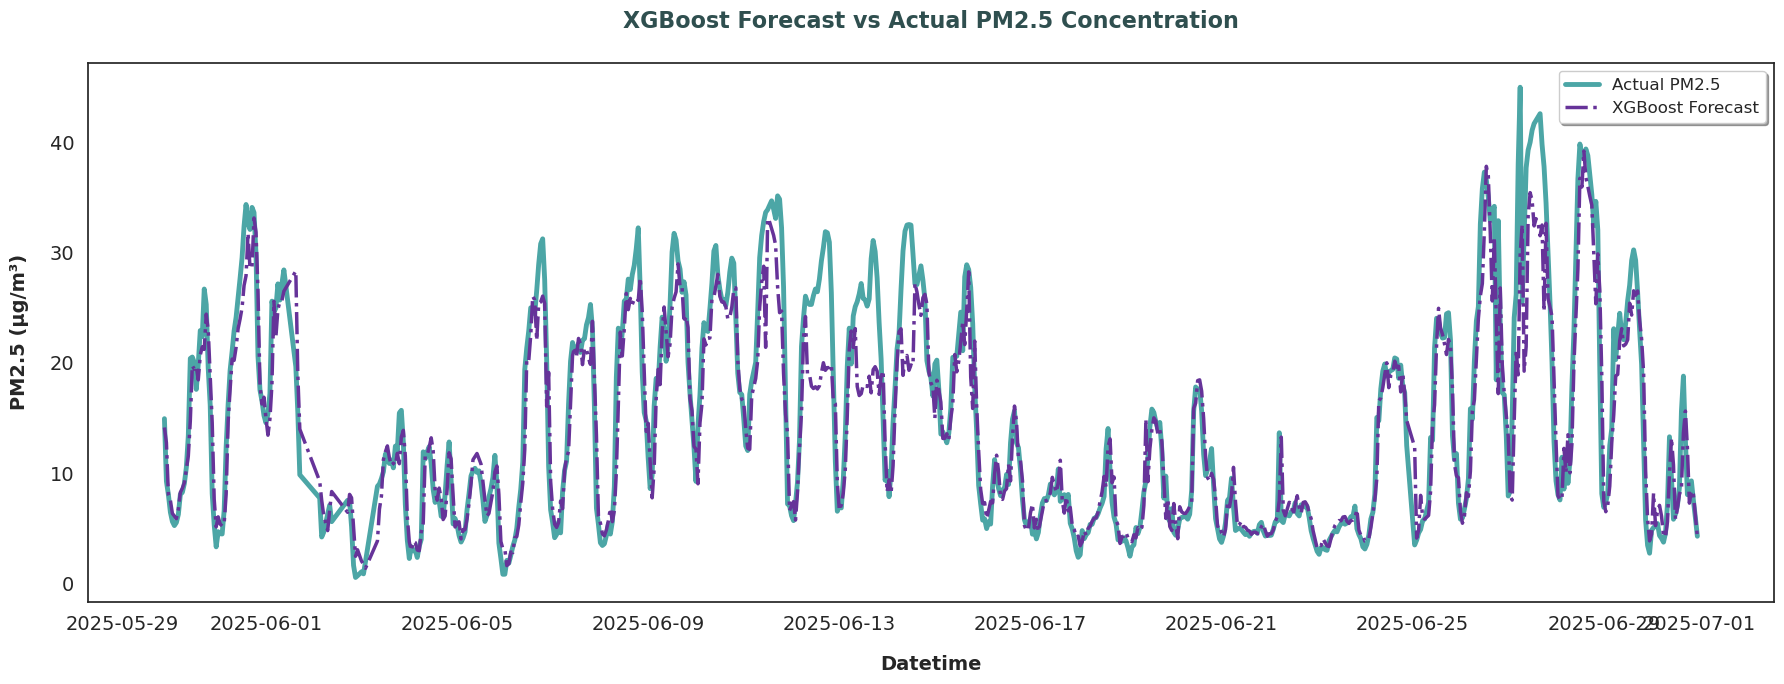

In [92]:
# Plot the forecast using the reusable function
plot_forecast(y_test, xgb_preds, "XGBoost", color_pred='rebeccapurple', linestyle_pred='-.')

Process: An XGBoost Regressor, an optimized gradient boosting framework known for its speed and performance, was trained on the same enhanced feature set. It sequentially builds trees, correcting errors from previous predictions. Parameters included n_estimators=100 and learning_rate=0.1.

Results: XGBoost also delivered strong performance, comparable to Random Forest:

MAE: 2.4692 µg/m³

RMSE: 3.7526 µg/m³

SMAPE: 18.1604%

The XGBoost forecast plot also demonstrated excellent alignment with actual PM2.5 values, accurately predicting many of the complex fluctuations.

__ML Model Comparison__

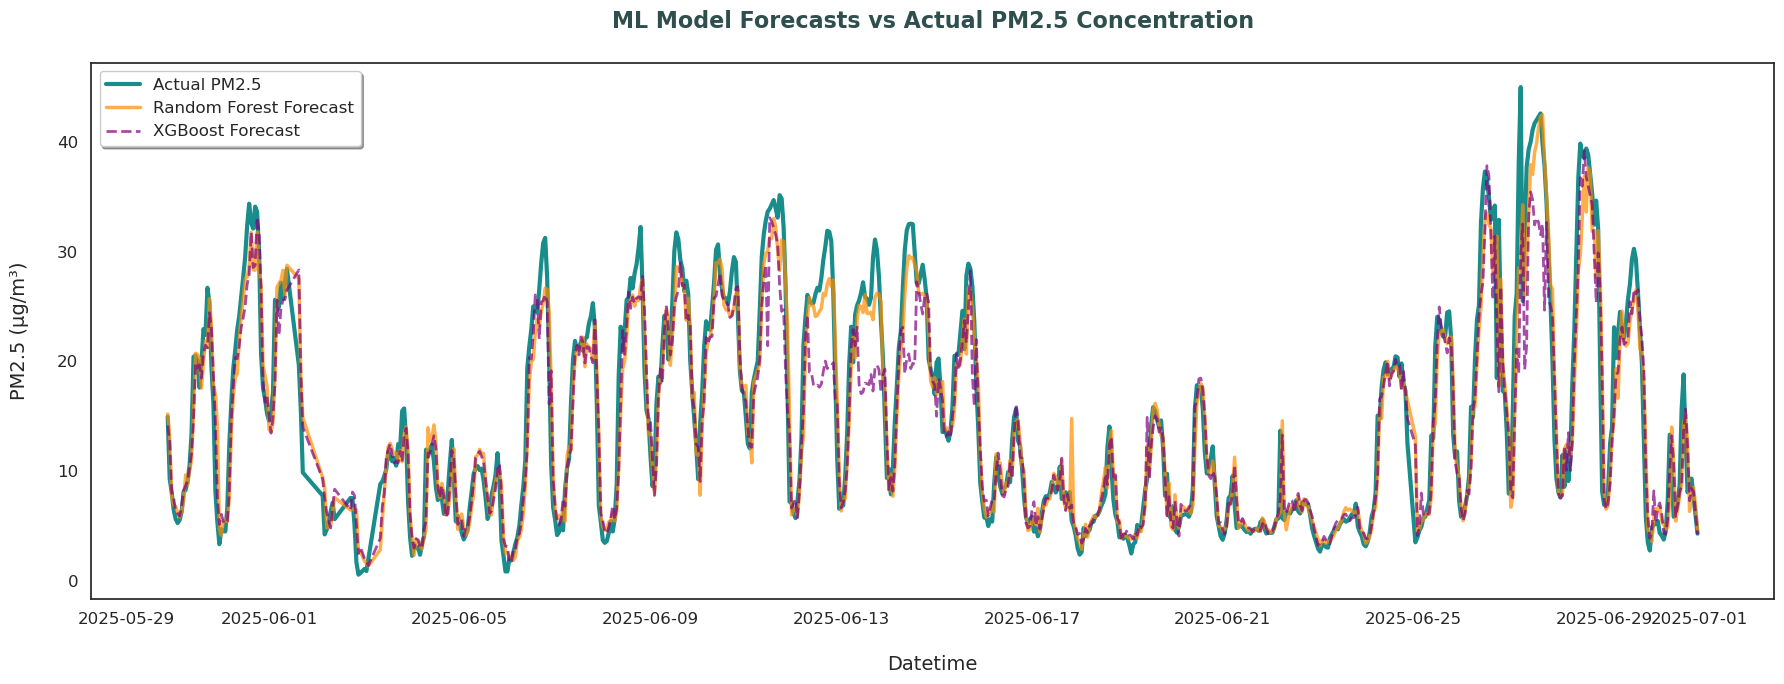

In [93]:
plt.figure(figsize=(18, 7))
# Plot Actual values
plt.plot(y_test.index, y_test.values, label="Actual PM2.5", color="teal", linewidth=3, alpha=0.9)

# Define plotting styles for clarity
model_plot_styles = {
    'Random Forest': {'color': 'darkorange', 'linestyle': '-', 'alpha': 0.7, 'linewidth': 2.5},
    'XGBoost': {'color': 'purple', 'linestyle': '--', 'alpha': 0.7, 'linewidth': 2}
}

# Plot each model's predictions
for model_name, preds_series in ml_predictions.items():
    styles = model_plot_styles.get(model_name, {'color': 'gray', 'linestyle': ':', 'alpha': 0.6, 'linewidth': 1.0})
    plt.plot(preds_series.index, preds_series, label=f"{model_name} Forecast",
             color=styles['color'], linestyle=styles['linestyle'], alpha=styles['alpha'], linewidth=styles['linewidth'])

plt.title("ML Model Forecasts vs Actual PM2.5 Concentration", fontsize=16, fontweight='bold', color='darkslategray', pad=25)
plt.ylabel("PM2.5 (µg/m³)", fontsize=14, labelpad=20)
plt.xlabel("Datetime", fontsize=14, labelpad=20)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12, frameon=True, shadow=True, loc='upper left') # Added loc for better placement
plt.tight_layout()
plt.show()

## Model Evaluation and Comparison

In [94]:
all_model_results = {
    "Random Forest": rf_metrics,
    "XGBoost": xgb_metrics,
    "SARIMA": sarima_metrics,
    "SARIMAX": sarimax_metrics
}

In [95]:
# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame.from_dict(all_model_results, orient='index')

# Optional: Sort by a specific metric (e.g., MAE) to easily see the best performers
results_df = results_df.sort_values(by='MAE', ascending=True)

print("--- Model Performance Comparison ---")
print(results_df)

--- Model Performance Comparison ---
                    MAE       RMSE      SMAPE
Random Forest  2.119231   3.025629  17.094744
XGBoost        2.469236   3.752576  18.160364
SARIMA         9.046175  12.223548  66.136517
SARIMAX        9.326576  12.683130  69.593034


From the comparison table, it's immediately clear that the Machine Learning models (Random Forest and XGBoost) significantly outperform both the traditional time series models (SARIMA and SARIMAX) across all three evaluation metrics (MAE, RMSE, and SMAPE).

Mean Absolute Error (MAE): This metric represents the average magnitude of errors in a set of forecasts, without considering their direction.

Random Forest has the lowest MAE (2.1192), indicating its predictions are, on average, closest to the actual values.

XGBoost is close behind (2.4692).

SARIMA and SARIMAX have much higher MAE values (around 9), suggesting their predictions deviate significantly more.

Root Mean Squared Error (RMSE): This metric gives a relatively high weight to large errors, as the errors are squared before they are averaged. This makes it useful when large errors are particularly undesirable.

Random Forest also has the lowest RMSE (3.0256), meaning it handles larger prediction errors better than the other models.

Again, XGBoost follows, while SARIMA and SARIMAX show considerably larger RMSE values (around 12-13).

Symmetric Mean Absolute Percentage Error (SMAPE): This is a percentage error, which makes it easy to interpret, especially when comparing models across different scales or datasets. It penalizes both positive and negative errors symmetrically.

Random Forest achieves the best SMAPE (17.0947%), meaning its forecasts are, on average, within about 17% of the actual values.

XGBoost is again second-best at around 18%.

SARIMA and SARIMAX show very high SMAPE values (above 60%), indicating a much poorer percentage accuracy.

In [96]:
# Prepare data for plotting - melt the DataFrame to long format for easier plotting with Seaborn
results_melted = results_df.reset_index().rename(columns={'index': 'Model'})
results_melted = results_melted.melt(id_vars='Model', var_name='Metric', value_name='Value')

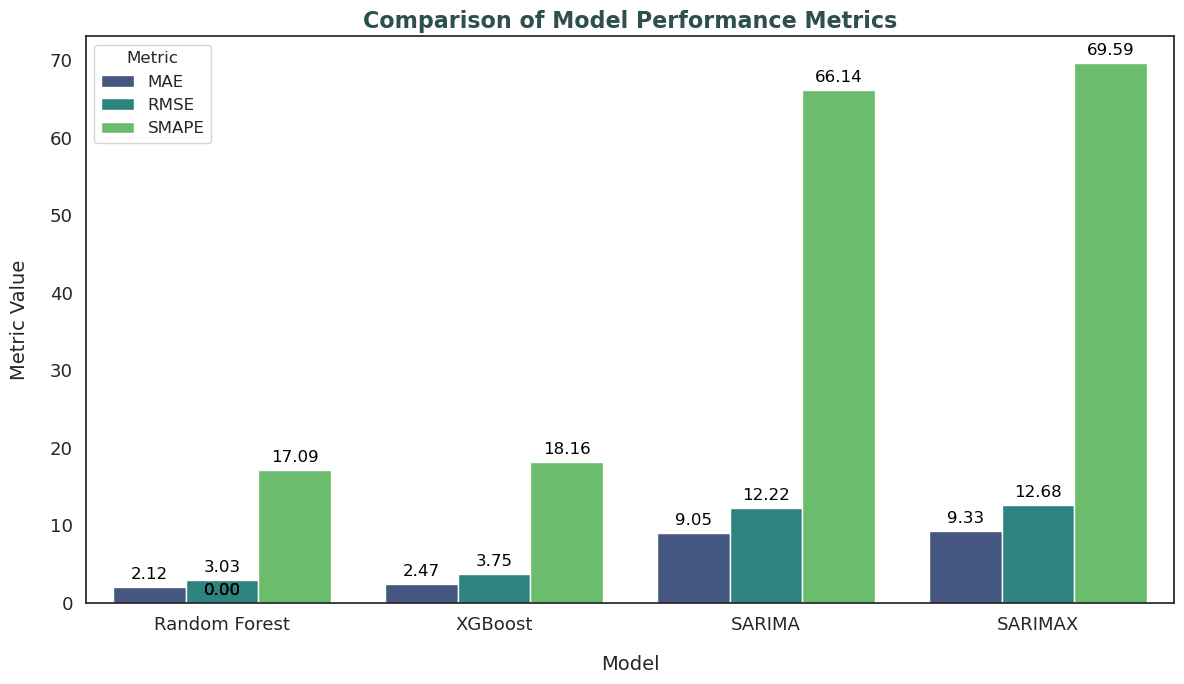

In [97]:
plt.figure(figsize=(12, 7))
bar_plot = sns.barplot(
    x='Model',
    y='Value',
    hue='Metric',
    data=results_melted,
    palette='viridis', # Choose a color palette
    errorbar=None # No error bars for single values
)
# Add value labels on top of the bars for each metric
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points',
                       fontsize=12,
                       color='black')

plt.title('Comparison of Model Performance Metrics', fontsize=16, fontweight='bold', color='darkslategray')
plt.xlabel('Model', fontsize=14, labelpad=15)
plt.ylabel('Metric Value', fontsize=14, labelpad=15)
plt.xticks(fontsize=13) # Rotate x-axis labels for readability
plt.yticks(fontsize=13)
plt.legend(title='Metric', fontsize=12, title_fontsize=12,loc='upper left')
plt.tight_layout()
plt.show()

Key Takeaways:
ML Models are Superior for this Dataset: The Random Forest Regressor is the clear winner among the models tested so far, demonstrating superior accuracy across MAE, RMSE, and SMAPE. XGBoost is a strong second. This strong performance likely stems from their ability to:

Capture Non-Linear Relationships: ML models can learn complex, non-linear patterns between features and the target that linear models like SARIMA/SARIMAX might miss.

Leverage Rich Features: By incorporating a wide range of features (weather, specific time-of-day/week, and crucially, lagged values and rolling averages of PM2.5 itself), the ML models had much more information to learn from. SARIMA/SARIMAX, especially in their basic form, primarily rely on the target's past values and a limited set of exogenous variables.

SARIMAX vs. SARIMA: In this specific comparison, SARIMA performed slightly better than SARIMAX. This could suggest that the chosen exogenous variables in SARIMAX, in their current form and without further tuning or transformation, did not add significant predictive power, or perhaps even introduced some noise or collinearity that slightly degraded performance compared to the pure ARIMA component.